In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter, CoxTimeVaryingFitter
from lifelines.statistics import logrank_test
from lifelines.utils import to_long_format, add_covariate_to_timeline, covariates_from_event_matrix

from scipy.stats import chi2, pearsonr, binom_test
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial
import matplotlib.colors

from functools import partial
import os

In [3]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

BIRTH_FIELD = "34-0.0"
SEX_FIELD = "31-0.0" # 0 female, 1 male
CHOLESTEROL_FIELD = "30690-0.0" 
DIABETES_FIELD = "2443-0.0"
CRP_FIELD = "30710-0.0"
HDL_FIELD = "30760-0.0"
SYSTOLIC_BP_FIELD = "4080-0.0"
PLT_FIELD = "30080-0.0"
MPV_FIELD = "30100-0.0"
PCT_FIELD = "30090-0.0"
PDW_FIELD = "30110-0.0"
BMI_FIELD = "21001-0.0"
genetic_PCs = ["22009-0.%d" % i for i in range(1,11)]
SMOKING_FIELD = "20161-0.0"

basics_X_cols = [SMOKING_FIELD] + genetic_PCs # ,BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD

In [4]:
UKB = pd.read_hdf("%s/UKB.hdf" % export_folder)

In [5]:
UKB.loc[UKB[SMOKING_FIELD].isnull(),SMOKING_FIELD] = 0.
UKB.loc[UKB[DIABETES_FIELD].isnull(),DIABETES_FIELD] = 0.
UKB.loc[UKB[DIABETES_FIELD] < 0,DIABETES_FIELD] = 0.
UKB[DIABETES_FIELD] = UKB[DIABETES_FIELD].astype(int)
UKB.loc[UKB[BMI_FIELD].isnull(),BMI_FIELD] = UKB.loc[~UKB[BMI_FIELD].isnull(),BMI_FIELD].mean()
UKB.loc[UKB[CHOLESTEROL_FIELD].isnull(),CHOLESTEROL_FIELD] = UKB.loc[~UKB[CHOLESTEROL_FIELD].isnull(),CHOLESTEROL_FIELD].mean()

In [6]:
UKB[DIABETES_FIELD].value_counts()

0    365593
1     18466
Name: 2443-0.0, dtype: int64

In [7]:
UKB[basics_X_cols].head(3)

,20161-0.0,22009-0.1,22009-0.2,22009-0.3,22009-0.4,22009-0.5,22009-0.6,22009-0.7,22009-0.8,22009-0.9,22009-0.10
eid,,,,,,,,,,,
1000011,0.0,-13.4848,1.06092,-3.047350,2.22877,-6.06503,-3.956770,0.877139,-0.901110,-1.835710,-0.401581
1000026,0.0,-13.2959,4.07063,0.425932,4.78868,1.00465,-0.544458,-2.408010,-1.404980,1.165280,0.278346
1000032,0.0,-15.4969,5.15194,-2.708700,4.22973,5.24573,-1.585010,2.513620,-0.968024,-0.302836,-1.710030


In [8]:
UKB.sample(3)

,31-0.0,34-0.0,845-0.0,2139-0.0,2217-0.0,2443-0.0,2714-0.0,2754-0.0,2764-0.0,2794-0.0,...,DRUG_228,DRUG_229,DRUG_230,DRUG_231,DRUG_232,DRUG_233,DRUG_234,DRUG_235,DRUG_236,AGE
eid,,,,,,,,,,,,,,,,,,,,,
2283143,0.0,1955-01-01,16.0,17.0,NaN,0,12.0,28.0,34.0,18.0,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,64.0
3296231,1.0,1947-01-01,NaN,16.0,23.0,1,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,72.0
3116781,1.0,1946-01-01,15.0,18.0,20.0,0,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,73.0


In [9]:
betas = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/betas.hdf" % export_folder,key="scores")

In [10]:
betas

SNP,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs3819288,...,rs61751937,rs10886430,rs7123827,rs11553699,rs61978213,rs59001897,rs8057254,rs12445050,rs11078475,rs1654425
ADP_pred,0.1248,0.069544,0.049249,0.057557,0.069758,0.074894,-0.047616,0.16771,-0.068151,0.083528,...,-0.169112,-0.068886,-0.043878,-0.13446,-0.124011,-0.055161,-0.055509,-0.107511,-0.045222,-0.091918
ALLELE1,G,C,T,G,G,T,G,C,A,T,...,G,A,A,A,G,T,T,C,T,T
COUNTED,T,T,C,A,A,C,A,T,G,C,...,C,G,C,G,A,A,A,T,C,C


In [11]:
scores = pd.read_hdf("%s/scores_table.hdf" % export_folder,key="scores")

In [12]:
scores.sample(3)

,INTERVAL_score,best_pval_score,best_pval_score_homogenous,rs12566888_T,rs1434282_T,rs41315846_C,rs13412535_A,rs78909033_A,rs1354034_C,rs13067286_A,...,rs8057254_A,rs12445050_T,rs11078475_C,rs1654425_C,rs17881225_C,rs12905925_C,PLT_score,MPV_score,PCT_score,PDW_score
1664387,0.130816,-0.070135,-0.423492,0.0,1.0,0.0,1.0,0.0,2.0,1.0,...,2.0,0.0,1.0,2.0,0.0,0.0,0.003644,-0.043503,-0.012340,0.004074
5582129,0.483499,-2.304678,-1.683141,1.0,2.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.009448,-0.026196,-0.006221,-0.001046
2943269,-0.780443,-1.160471,-0.763968,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.013155,-0.055459,-0.009053,-0.018297


In [13]:
X = pd.merge(UKB, scores, left_index=True,right_index=True,how="inner")

In [14]:
X[CRP_FIELD] = X[CRP_FIELD].fillna(X[CRP_FIELD].mean())
X[SYSTOLIC_BP_FIELD] = X[SYSTOLIC_BP_FIELD].fillna(X[SYSTOLIC_BP_FIELD].mean())

In [15]:
assert X[basics_X_cols].isnull().sum(axis=0).sum() == 0

In [16]:
# Done loading X

In [17]:
#all_ICD10_events = pd.read_csv("%s/ICD10_events.csv" % export_folder,index_col=0)
#all_ICD10_events["Date"] = pd.to_datetime(all_ICD10_events.Date)
#print(all_ICD10_events.shape)

In [18]:
X.shape

(384059, 1970)

In [19]:
ICD10_sec_desc = pd.read_csv("%s/coding19.tsv" % export_folder, sep="\t").set_index("coding")["meaning"].to_dict()

In [20]:
coag_related_codes = ["I21","I25","I26","I80","H40"]
ICD10_sec_desc["meta_coag"] = "Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)"
for code in coag_related_codes:
    print(ICD10_sec_desc[code])

I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I26 Pulmonary embolism
I80 Phlebitis and thrombophlebitis
H40 Glaucoma


In [21]:
all_ICD10_events = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/phenotypes.csv")
all_ICD10_events = all_ICD10_events.loc[all_ICD10_events.pheno_type == "ICD10-UKB"]
all_ICD10_events = all_ICD10_events.rename(columns={"pheno_id":"code","age":"AGE_AT_EVENT","sample_id":"ID"})
all_ICD10_events = all_ICD10_events[["code","AGE_AT_EVENT","ID"]]

print(all_ICD10_events.shape)

all_ICD10_events_shortcodes = all_ICD10_events.copy()
all_ICD10_events_shortcodes["code"] = all_ICD10_events_shortcodes["code"].str.split(".",expand=True)[0]
all_ICD10_events_shortcodes = all_ICD10_events_shortcodes.loc[~all_ICD10_events_shortcodes.code.isin(all_ICD10_events.code.unique().tolist())]
print(all_ICD10_events.code.nunique())
print(all_ICD10_events_shortcodes.code.nunique())
all_ICD10_events = pd.concat([all_ICD10_events,all_ICD10_events_shortcodes],axis=0)
print(all_ICD10_events.code.nunique())

print(all_ICD10_events.shape)

/home/hv270/platelets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5989813, 3)
12222
1655
13877
(11008703, 3)


In [22]:
diabetes_events = all_ICD10_events.loc[all_ICD10_events.code.str.contains("E08") |\
                                       all_ICD10_events.code.str.contains("E09") |\
                                       all_ICD10_events.code.str.contains("E10") |\
                                       all_ICD10_events.code.str.contains("E11") |\
                                       all_ICD10_events.code.str.contains("E12") |\
                                       all_ICD10_events.code.str.contains("E13")]

In [23]:
first_diabete = diabetes_events.groupby("ID")[["AGE_AT_EVENT"]].min().reset_index()\
    .rename(columns={"AGE_AT_EVENT":"AGE_AT_DIABETES"})

In [24]:
diabetes_IDs = first_diabete.ID.tolist()
diabetes_codes = diabetes_events.code.unique().tolist()

In [25]:
X = pd.merge(X,first_diabete,left_index=True,right_on="ID",how="left").set_index("ID")
X["AGE_AT_DIABETES"].fillna(np.inf,inplace=True)

In [26]:
meta_coag_events = all_ICD10_events.loc[all_ICD10_events.code.isin(coag_related_codes)].groupby("ID").agg({"AGE_AT_EVENT":"min"}).reset_index()
meta_coag_events["code"] = "meta_coag"
meta_coag_events = meta_coag_events[["code","AGE_AT_EVENT","ID"]]
all_ICD10_events = pd.concat([all_ICD10_events,meta_coag_events],axis=0)
meta_coag_events.head()

,code,AGE_AT_EVENT,ID
0,meta_coag,62.0,1000044
1,meta_coag,60.0,1000150
2,meta_coag,74.0,1000195
3,meta_coag,65.0,1000252
4,meta_coag,58.0,1000289


In [27]:
X["SMOKING_BOOL"] = (X[SMOKING_FIELD] >= 3)*1

In [28]:
X["SMOKING_RATE"] = np.clip((X[SMOKING_FIELD] - 15)/X["AGE"],a_min=0,a_max=2)

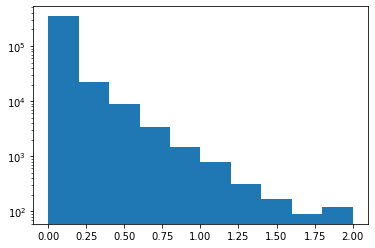

In [29]:
plt.hist(X["SMOKING_RATE"])
plt.yscale("log")

In [30]:
X[CRP_FIELD] = np.clip(X[CRP_FIELD],a_min=0,a_max=10)

In [31]:
X["AGE_int"] = np.floor(X["AGE"])

(array([3.24000e+02, 4.49850e+04, 1.47161e+05, 1.00747e+05, 3.45850e+04,
        7.62200e+03, 1.25400e+03, 2.38000e+02, 3.00000e+01, 1.00000e+01]),
 array([0.219 , 0.6372, 1.0554, 1.4736, 1.8918, 2.31  , 2.7282, 3.1464,
        3.5646, 3.9828, 4.401 ]),
 <a list of 10 Patch objects>)

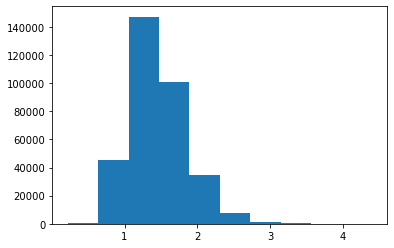

In [32]:
plt.hist(X[HDL_FIELD])

In [33]:
# Doing the PH test, we found that smoking and cholesterol are age-related and should thus be used more as strata
for c in ["SMOKING_RATE",CHOLESTEROL_FIELD,HDL_FIELD,CRP_FIELD,SYSTOLIC_BP_FIELD]:
    X[c].fillna(X[c].median(),inplace=True)
X["SMOKING_RATE_bin"] = pd.cut(X["SMOKING_RATE"],bins=[-0.001,0.0001,.5,2.01],labels=False)
X["CHOLESTEROL_bin"] = pd.qcut(X[CHOLESTEROL_FIELD],4,labels=False)
X["HDL_bin"] = pd.qcut(X[HDL_FIELD],3,labels=False)
X["CRP_bin"] = pd.qcut(X[CRP_FIELD],4,labels=False)
X["SYSTOLIC_BP_bin"] = pd.qcut(X[SYSTOLIC_BP_FIELD],3,labels=False)

In [34]:
2*3*4*3*4*3

864

In [35]:
sysmex_covars = ["MPV_score","PLT_score","PDW_score","PCT_score"]  # ,"IPF_score"
pheno_cols_to_norm = [c for c in list(scores.columns) if c not in sysmex_covars]
cols_to_normalize = sysmex_covars + pheno_cols_to_norm #+ [SMOKING_FIELD]
X[cols_to_normalize] -= X[cols_to_normalize].mean(axis=0)
X[cols_to_normalize] /= X[cols_to_normalize].std(axis=0)

In [36]:
# Create decomposition of sysmex covariates so that they don't correlate
pc_covars_cols = ["sysmex_PC_%d" % i for i in range(len(sysmex_covars))]
pca = PCA()
X[pc_covars_cols] = pca.fit_transform(X[sysmex_covars])
X[pc_covars_cols] -= X[pc_covars_cols].mean(axis=0)
X[pc_covars_cols] /= X[pc_covars_cols].std(axis=0)

In [37]:
all_codes = all_ICD10_events.code.unique().tolist()

In [38]:
first_thrombosis = all_ICD10_events_shortcodes.loc[
    all_ICD10_events_shortcodes.code.isin(["I20","I21","I22","I23","I24","I25","I26","I80","I81","I82"])
].sort_values("AGE_AT_EVENT").groupby("ID").first().rename(columns={"AGE_AT_EVENT":"AGE_COAG_EVENT"})
print(first_thrombosis.shape)
#first_thrombosis["AGE_COAG_EVENT"] -= 1 # Pour être sûr que si jamais la purpura et la coagulation arrivent la même année, on aura quand même ici la coag avant
first_thrombosis.head()

(69222, 2)


,code,AGE_COAG_EVENT
ID,,
1000044,I20,62.0
1000150,I25,60.0
1000195,I25,74.0
1000252,I25,65.0
1000289,I80,58.0


In [39]:
if "AGE_COAG_EVENT" in X.columns:
    del X["AGE_COAG_EVENT"]
X = pd.merge(X, first_thrombosis[["AGE_COAG_EVENT"]],left_index=True,right_index=True,how="left")
X["AGE_COAG_EVENT"].fillna(np.inf,inplace=True)

In [40]:
has_coag = X["AGE_COAG_EVENT"] < np.inf
print("%d percent of people who have coag have it at the age of measurement" % 
      (100*(X.loc[has_coag,"AGE"] <= X.loc[has_coag,"AGE_COAG_EVENT"]).mean())
     )
X.loc[has_coag,"AGE"] = X.loc[has_coag,["AGE","AGE_COAG_EVENT"]].max(axis=1)

15 percent of people who have coag have it at the age of measurement


In [41]:
drug_columns = pd.read_csv("%s/drug_columns.hdf" % export_folder,index_col=0)

In [42]:
X["AGE_DRUG"] = ((X["DRUG_236"] - X[BIRTH_FIELD]).dt.days // 365).fillna(np.inf)

In [43]:
X["AGE_DRUG_OR_COAG"] = X[["AGE_DRUG","AGE_COAG_EVENT"]].min(axis=1)

In [44]:
X = X.loc[X[[PLT_FIELD, MPV_FIELD, PCT_FIELD, PDW_FIELD]].isnull().sum(axis=1) == 0]

In [45]:
covariates_sets = {
    #"none":[],
    "PLT-MPV-PCT-PDW":[PLT_FIELD, MPV_FIELD, PCT_FIELD, PDW_FIELD],
}
T_cols = {
    "default":"AGE",
    #"first_anticoag_or_drug":"AGE_DRUG_OR_COAG"
} # End of inclusion
add_more_sets = False
if add_more_sets:    
    for c in X.columns:
        if c[:4] == "DRUG":
            drug_name = drug_columns.loc[drug_columns.drug_ID == c,"drug"].iloc[0]
            if "(any)" in drug_name:
                covariates_sets[drug_name] = [c]
variable_covariates_to_simplify = []
for d, cols in covariates_sets.items():
    variable_covariates_to_simplify += [c for c in cols if "DRUG" in c]

In [46]:
all_covariates_ = []
for b in covariates_sets:
    all_covariates_ = all_covariates_ + covariates_sets[b]

In [47]:
strata_bins = ["SMOKING_RATE_bin","CRP_bin","CHOLESTEROL_bin","HDL_bin","SYSTOLIC_BP_bin"]

In [48]:
# mandatory_cols : columns needed for any CoxPH
mandatory_cols = [BIRTH_FIELD,SEX_FIELD,"AGE","AGE_AT_DIABETES","AGE_COAG_EVENT","AGE_DRUG","AGE_DRUG_OR_COAG"] + strata_bins

# Functions

In [49]:
# Refaire marcher dans le cas constant
# Et faire marcher si possible dans le cas variable

min_n_cases = 1000

def do_cox_test(args, variables_to_test, IDs_to_include=None):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: 
        print("n_cases = %d <= %d"% (n_cases,min_n_cases))
        return None
    
    res = {
        "p_val":[],
        "desc":[],
        "log_HR":[],
        "code":[],
        "covariates":[],
        "n_cases":[],
        "include_until":[],
        "score":[]
    }
    
    for t_col_name, t_col in T_cols.items():
        X_ = pd.merge(X[mandatory_cols + list(set([c for c in all_covariates_ if c in X.columns] + pc_covars_cols + pheno_cols))],
                      events,left_index=True,right_on="ID",how="left").copy()
        X_ = X_.loc[X_[mandatory_cols].isnull().sum(axis=1) == 0]
        if IDs_to_include is not None:
            X_ = X_.loc[X_.ID.isin(IDs_to_include)]
    
        # Make sure that events really happen before the age at measurement.
        # If they happen more than 1 year before AGE, it's fine, there will be no 'rounding' effect due to int ages
        has_event = ~X_.AGE_AT_EVENT.isnull()
        #print("Mean age before correction %.2f" % X_["AGE"].mean())
        #X_.loc[has_event, "AGE"] = X_.loc[has_event,["AGE","AGE_AT_EVENT"]].max(axis=1)
        X_.loc[X_[t_col] < np.inf, "AGE"] = X_.loc[X_[t_col] < np.inf,["AGE",t_col,"AGE_AT_EVENT"]].max(axis=1)
        #print("Mean age after correction %.2f" % X_["AGE"].mean())
    
        #print("%d peole" % X_.shape[0])
        X_["T"] = X_[["AGE",t_col,"AGE_AT_EVENT"]].copy().min(axis=1).astype(float)
        #print("mean age %.2f" % X_["AGE"].mean())
        #print("mean time of measurement %.2f" % X_["T"].mean())
        #print("mean time of event %.2f" % X_.loc[has_event,"T"].mean())
        #print("%d cases" % has_event.sum())
        X_["EVENT"] = has_event
        if t_col != "AGE":
            #X_["EVENT"] = X_["EVENT"] & (X_["AGE_AT_EVENT"] < X_[t_col])
            #X_.loc[X_.EVENT,"EVENT"]
            X_.loc[X_["T"] < X_["AGE_AT_EVENT"],"EVENT"] = False
            X_.loc[X_[t_col] <= X_["AGE_AT_EVENT"],"EVENT"] = False
        
        #print("For those who have the event %s - %s" % ("T","AGE_AT_EVENT"))
        #print((X_.loc[X_.EVENT,"T"] - X_.loc[X_.EVENT,"AGE_AT_EVENT"]).value_counts().head())
        
        #print("For those who have the event and t_col %s - %s" % (t_col,"AGE_AT_EVENT"))
        #print((X_.loc[X_.EVENT & (X_[t_col] < np.inf),t_col] - X_.loc[X_.EVENT & (X_[t_col] < np.inf),"AGE_AT_EVENT"]).value_counts().head())
        
        
        
        #print("%d cases before %s" % (X_["EVENT"].sum(),t_col))
        X_["EVENT"] = X_["EVENT"]*1
        X_["HAD_DIABETES_BEFORE"] = X_["AGE_AT_DIABETES"] < X_["T"]
        X_["HAD_COAG_BEFORE"] = X_["AGE_COAG_EVENT"] < X_["T"]
        
        #print("T = %s, mean age at event = %.2f" % (t_col_name, X_.loc[has_event,"T"].mean()))
        del X_["AGE_AT_DIABETES"]
        del X_["AGE_COAG_EVENT"]
        assert X_["T"].isnull().sum() == 0
        
        # Re-do this for columns in variable_covariates_to_simplify
        # First convert to age

        tv_covariates = []
        fixed_covariates = []

        for c in all_covariates_:
            if "M" in X_[c].dtype.kind:
                # Date -> age
                X_[c] = ((X_[c] - X_[BIRTH_FIELD]).dt.days // 365).astype(float)
                X_[c].fillna(np.inf, inplace=True)
                assert X_[c].min() >= 0, X_[c].min()
                if c in variable_covariates_to_simplify:
                    # In this case, we only look at whether the event occured before or after the covariate event.
                    X_[c] = X_[c] < X_["T"]
                    fixed_covariates.append(c)
                else:
                    tv_covariates.append(c)
            else:
                fixed_covariates.append(c)

        #print("%d tv covariates and %d fixed" % (len(tv_covariates), len(fixed_covariates)))


        # find if unisex
        n_cases = X_.EVENT.sum()
        valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
        valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
        unisex = len(valid_sexes) == 1
        if unisex:
            desc += " (unisex)"

        # Define people to include and strata
        to_include = X_[SEX_FIELD].isin(valid_sexes)
        strata = [SEX_FIELD] if not unisex else []
        strata += strata_bins

        pen_args = {"penalizer":0.0,"l1_ratio":1.}
        fit_args = {"duration_col":"duration","event_col":"EVENT","strata":strata,
                    "show_progress":False,"step_size":.5}

        X_ = X_.loc[to_include]
        X_ = X_.rename(columns={"T":"duration"})
        n_cases = X_.EVENT.sum()
        if n_cases <= min_n_cases: 
            continue

        basics = ["ID","duration","EVENT"] + strata
        all_cols_to_include = basics + variables_to_test + all_covariates_ 

        df = X_[all_cols_to_include]

        base_df = df[basics + variables_to_test + fixed_covariates].reset_index(drop=True)
        need_time_varying = len(tv_covariates) > 0
        if need_time_varying:
            print("Need time varying things")
            cv = covariates_from_event_matrix(df[["ID"] + tv_covariates], id_col="ID")
            base_df = to_long_format(base_df,duration_col="duration")
            base_df = add_covariate_to_timeline(base_df, cv, duration_col="duration", id_col="ID", event_col="EVENT")
        df_to_fit = base_df.set_index("ID")
        
         

        for covars_group, covars in covariates_sets.items():

            if need_time_varying:
                aft1 = CoxTimeVaryingFitter(penalizer=0.1)
                cols_to_include_1 = strata + covars + ["ID","EVENT","stop","start"]

            else:
                aft1 = CoxPHFitter(**pen_args)
                cols_to_include_1 = basics + covars
            cols_to_include_1.remove("ID")

            #print("Fitting model with covars %s" % covars)
            aft1.fit(df_to_fit[cols_to_include_1], **fit_args) 

            #aft1.print_summary()

            for target in variables_to_test:
                cols_to_include_2 = cols_to_include_1 + [target]
                aft2 = CoxPHFitter(**pen_args)
                #print("Fitting model on %s" % target)
                aft2.fit(df_to_fit[cols_to_include_2], **fit_args)

                LL_without = aft1.log_likelihood_
                LL_with = aft2.log_likelihood_
                Delta_LL = LL_with-LL_without
                p_val = 1.-chi2(1).cdf(2*Delta_LL)

                HR = aft2.hazard_ratios_[target]

                description = ""
                description += "| %s \t| %s : %.2f\t" % (target, covars_group,-np.log10(p_val))
                description += "%d cases \t %s \t %s" % (n_cases, code, desc)

                if p_val < 1e-3:

                    print("==========================")
                    print(description)
                    print("==========================")
                    aft2.print_summary()
                
                res["p_val"].append(p_val)
                res["log_HR"].append(np.log(HR))
                res["desc"].append(desc)
                res["code"].append(code)
                res["covariates"].append(covars_group)
                res["n_cases"].append(n_cases)
                res["include_until"].append(t_col_name)
                res["score"].append(target)
    
    return res

# Test SNPs separately

In [50]:
#pheno_cols = [c for c in list(scores.columns) if c not in sysmex_covars]
SNP_cols = [c for c in list(scores.columns) if "rs" in c]
pheno_cols = ["best_pval_score_homogenous"] #+ SNP_cols
for c in pheno_cols:
    assert c in scores.columns

In [51]:
pheno_cols

['best_pval_score_homogenous']

In [52]:
run_name = "8_avril_sysmex_covars"
run_dir = "/home/hv270/cox/%s" % run_name
force_recompute = True
if not os.path.exists(run_dir):
    os.mkdir(run_dir)


code_file = lambda code: "%s/%s.csv" % (run_dir, code)

n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events) & ~all_ICD10_events.code.isin(diabetes_codes)

already_processed_codes = [c for c in all_ICD10_events.loc[cond].code.unique().tolist() if os.path.exists(code_file(c))]
print("%d already processed codes" % len(already_processed_codes))
if not force_recompute:
    cond = cond & ~all_ICD10_events.code.isin(already_processed_codes)

#codes_to_focus_on = ["D69","I26","I21","I80","I25"] # Thrombosis
#codes_to_focus_on = ["I26","I21"]
codes_to_focus_on = []
#codes_to_focus_on = ["I26","I26.9","Z86.7","I21","I80","D69","meta_coag","D69.6","I25","M72.04","I51","T43"]
if len(codes_to_focus_on) > 0:
    cond = cond & all_ICD10_events.code.isin(codes_to_focus_on)
n_codes_to_process = all_ICD10_events.loc[cond].code.nunique()
print("%d codes to process" % n_codes_to_process)

1183 already processed codes
1435 codes to process


In [53]:
do_cox_test_pheno = partial(do_cox_test,variables_to_test=pheno_cols)#,IDs_to_include = IDs_no_anti_coag

In [54]:
#results = []
#for arg in all_ICD10_events.loc[cond].groupby("code"):
#    print(arg[0])
#    results.append(do_cox_test_pheno(arg))

In [55]:
#results_df = pd.concat([pd.DataFrame.from_dict(d) for d in results],axis=0)

In [ ]:
p = Pool(16)

for res in tqdm(p.imap_unordered(do_cox_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=n_codes_to_process):
    if res is None: continue
    if len(res["code"]) == 0: 
        print("res empty")
        continue
    print("res OK %s" % res["code"][0])
    df = pd.DataFrame.from_dict(res)
    code = res["code"][0]
    df.to_csv(code_file(code))
p.close()
p.join()

  0%|          | 1/1435 [00:02<54:01,  2.26s/it]

res empty


  0%|          | 2/1435 [03:54<54:48:02, 137.67s/it]

res OK B37.0


  0%|          | 3/1435 [03:58<30:28:24, 76.61s/it] 

res OK B07


  0%|          | 4/1435 [04:01<18:48:42, 47.33s/it]

res OK B34.9
res OK B37.8


  0%|          | 6/1435 [04:02<8:04:00, 20.32s/it] 

res empty


  0%|          | 7/1435 [04:02<5:28:33, 13.80s/it]

res OK A49


  1%|          | 8/1435 [04:03<3:47:02,  9.55s/it]

res empty


  1%|          | 9/1435 [04:04<2:44:42,  6.93s/it]

res OK A41.5


  1%|          | 10/1435 [04:04<1:56:18,  4.90s/it]

res OK A08.4


  1%|          | 11/1435 [04:05<1:23:30,  3.52s/it]

res OK B34


  1%|          | 12/1435 [04:06<1:04:46,  2.73s/it]

res OK A08
res OK B37


  1%|          | 14/1435 [04:06<36:28,  1.54s/it]  

res OK A41
res empty


  1%|          | 17/1435 [04:06<18:54,  1.25it/s]

res OK A41.9
res OK A04.7


  1%|▏         | 18/1435 [04:07<17:45,  1.33it/s]

res OK A09.9


  1%|▏         | 19/1435 [04:08<19:12,  1.23it/s]

res OK A04.8


  1%|▏         | 20/1435 [04:08<15:39,  1.51it/s]

res OK A04


  1%|▏         | 21/1435 [07:47<23:57:12, 60.99s/it]

res OK B95


  2%|▏         | 22/1435 [07:55<18:02:43, 45.98s/it]

res OK B95.4


  2%|▏         | 23/1435 [07:59<13:19:31, 33.97s/it]

res OK B95.6


  2%|▏         | 24/1435 [08:00<9:32:27, 24.34s/it] 

res OK B96.2


  2%|▏         | 25/1435 [08:02<6:58:57, 17.83s/it]

res OK B98


  2%|▏         | 26/1435 [08:03<4:59:36, 12.76s/it]

res OK B96


  2%|▏         | 27/1435 [08:04<3:39:31,  9.35s/it]

res OK B97


  2%|▏         | 28/1435 [08:06<2:42:25,  6.93s/it]

res OK B96.5


  2%|▏         | 30/1435 [08:07<1:26:54,  3.71s/it]

res OK B98.0
res OK C15.9


  2%|▏         | 31/1435 [08:09<1:13:29,  3.14s/it]

res OK B96.8
res OK C15


  2%|▏         | 33/1435 [08:09<41:48,  1.79s/it]  

res empty
| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 3.63	1579 cases 	 C16 	 C16 Malignant neoplasm of stomach


  2%|▏         | 35/1435 [08:10<25:21,  1.09s/it]

res OK C18.0
res empty


<lifelines.CoxPHFitter: fitted with 384667 total observations, 383088 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384667
number of events observed = 1579
   partial log-likelihood = -9077.23
         time fit was run = 2023-04-08 11:03:46 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
30100-0.0                   -0.05       0.95       0.09            -0.23             0.12                 0.79                 1.13
30090-0.0                    0.45       1.57       3.77            -6.94             7.84                 0.00              2539.40
30110-0.0                   -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.09
best_pval_score_homogenous   0.09       1.10       0.03             0.04             0.14                 1.04                 1.15

                               z      p   -log2(p)
covariate                                         
30080-0.0                   0.33   0.74       0.43
30100-0.0                  -0.59   0.55       0.86
30090-0.0                   0.12   0.90       0.14
30110-0.0                  -0.39   0.70       0.51
best_pval_score_homogenous  3.68 <0.005      12.06
---
Concordance = 0.50
Partial AIC = 18164.46
log-likelihood ratio test = 32.70 on 5 df
-log2(p) of ll-ratio test = 17.82

  3%|▎         | 36/1435 [08:10<23:08,  1.01it/s]

res OK C16


  3%|▎         | 37/1435 [08:11<21:29,  1.08it/s]

res OK C18


  3%|▎         | 38/1435 [08:13<26:56,  1.16s/it]

res OK C18.7


  3%|▎         | 39/1435 [11:35<23:02:07, 59.40s/it]

res OK C18.9


  3%|▎         | 40/1435 [11:48<17:42:25, 45.70s/it]

res OK C19


  3%|▎         | 41/1435 [11:55<13:19:28, 34.41s/it]

res OK C20


  3%|▎         | 42/1435 [11:58<9:42:55, 25.11s/it] 

res OK C25


  3%|▎         | 43/1435 [11:59<6:51:56, 17.76s/it]

res empty
res OK C22


  3%|▎         | 45/1435 [11:59<3:44:52,  9.71s/it]

res empty


  3%|▎         | 46/1435 [12:00<2:51:52,  7.42s/it]

res OK C25.9


  3%|▎         | 47/1435 [12:04<2:35:56,  6.74s/it]

res OK C34.3


  3%|▎         | 48/1435 [12:05<2:00:14,  5.20s/it]

res OK C34.1


  3%|▎         | 49/1435 [12:06<1:29:21,  3.87s/it]

res OK C34


  3%|▎         | 50/1435 [12:08<1:17:43,  3.37s/it]

res OK C43


  4%|▎         | 51/1435 [12:08<58:32,  2.54s/it]  

res OK C34.9


  4%|▎         | 52/1435 [12:11<58:06,  2.52s/it]

res OK C44.2
res OK C44.1


  4%|▍         | 54/1435 [12:14<45:45,  1.99s/it]

res OK C44.3


  4%|▍         | 55/1435 [12:14<37:44,  1.64s/it]

res OK C44.4


  4%|▍         | 56/1435 [12:14<29:32,  1.29s/it]

res OK C44


  4%|▍         | 57/1435 [12:15<22:57,  1.00it/s]

res empty


  4%|▍         | 59/1435 [13:45<7:06:46, 18.61s/it]

res OK C50
res OK C50.4


  4%|▍         | 60/1435 [13:48<5:19:21, 13.94s/it]

res OK C50.9


  4%|▍         | 61/1435 [13:49<3:55:29, 10.28s/it]

res OK C54


  4%|▍         | 62/1435 [13:50<2:48:45,  7.38s/it]

res empty


  4%|▍         | 63/1435 [13:50<2:01:46,  5.33s/it]

res OK C56
res empty


  5%|▍         | 65/1435 [13:51<1:12:14,  3.16s/it]

res OK C54.1


  5%|▍         | 66/1435 [13:55<1:14:19,  3.26s/it]

res OK C61


  5%|▍         | 67/1435 [15:27<9:59:52, 26.31s/it]

res OK C44.5


  5%|▍         | 68/1435 [15:41<8:46:30, 23.11s/it]

res OK C44.6


  5%|▍         | 69/1435 [15:51<7:23:45, 19.49s/it]

res OK C44.7


  5%|▍         | 70/1435 [16:04<6:39:38, 17.57s/it]

res OK C64


  5%|▌         | 72/1435 [16:13<4:04:40, 10.77s/it]

res OK C71
res OK C67.9
res OK C67


  5%|▌         | 74/1435 [16:15<2:20:25,  6.19s/it]

res OK C77.0


  5%|▌         | 75/1435 [16:16<1:53:33,  5.01s/it]

res OK C77


  5%|▌         | 76/1435 [17:31<8:41:01, 23.00s/it]

res OK C77.1


  5%|▌         | 77/1435 [17:31<6:24:12, 16.98s/it]

res empty


  5%|▌         | 78/1435 [17:40<5:31:23, 14.65s/it]

res OK C77.2


  6%|▌         | 79/1435 [17:40<3:58:51, 10.57s/it]

res OK C77.3
res empty


  6%|▌         | 81/1435 [17:41<2:13:46,  5.93s/it]

res empty


  6%|▌         | 82/1435 [17:41<1:43:20,  4.58s/it]

res empty


  6%|▌         | 83/1435 [17:41<1:18:50,  3.50s/it]

res empty


  6%|▌         | 84/1435 [17:42<59:50,  2.66s/it]  

res empty


  6%|▌         | 85/1435 [17:42<45:47,  2.03s/it]

res empty


  6%|▌         | 86/1435 [17:43<35:10,  1.56s/it]

res empty


  6%|▌         | 87/1435 [17:43<27:23,  1.22s/it]

res empty


  6%|▌         | 88/1435 [17:43<21:45,  1.03it/s]

res empty


  6%|▌         | 89/1435 [17:46<35:25,  1.58s/it]

res OK C78.0


  6%|▋         | 90/1435 [17:47<28:05,  1.25s/it]

res OK C78.2


  6%|▋         | 91/1435 [17:49<34:34,  1.54s/it]

res OK C78


  6%|▋         | 92/1435 [17:53<46:56,  2.10s/it]

res OK C78.6


  6%|▋         | 93/1435 [19:16<9:47:05, 26.25s/it]

res OK C78.7


  7%|▋         | 94/1435 [19:32<8:41:23, 23.33s/it]

res OK D05


  7%|▋         | 95/1435 [19:32<6:08:17, 16.49s/it]

res OK D05.1


  7%|▋         | 96/1435 [19:38<4:57:50, 13.35s/it]

res OK C79


  7%|▋         | 97/1435 [19:40<3:37:36,  9.76s/it]

res OK D05.9


  7%|▋         | 98/1435 [19:46<3:16:02,  8.80s/it]

res OK C79.3


  7%|▋         | 99/1435 [20:02<4:03:39, 10.94s/it]

res OK C79.5


  7%|▋         | 100/1435 [20:12<3:56:04, 10.61s/it]

res OK C79.8


  7%|▋         | 101/1435 [20:15<3:03:17,  8.24s/it]

res OK C80


  7%|▋         | 102/1435 [20:18<2:26:54,  6.61s/it]

res OK C80.9


  7%|▋         | 103/1435 [20:18<1:44:57,  4.73s/it]

res OK C80.0


  7%|▋         | 104/1435 [20:18<1:14:47,  3.37s/it]

res empty


  7%|▋         | 105/1435 [20:19<58:52,  2.66s/it]  

res OK C79.9


  7%|▋         | 106/1435 [21:21<7:31:35, 20.39s/it]

res OK C83


  7%|▋         | 107/1435 [21:34<6:44:55, 18.29s/it]

res OK C85


  8%|▊         | 108/1435 [21:39<5:12:42, 14.14s/it]

res OK D03


  8%|▊         | 109/1435 [21:44<4:15:35, 11.57s/it]

res OK D04


  8%|▊         | 110/1435 [23:14<12:49:39, 34.85s/it]

res OK D12
res OK D17.6


  8%|▊         | 112/1435 [23:27<8:01:58, 21.86s/it] 

res OK D12.0


  8%|▊         | 113/1435 [23:28<6:06:20, 16.63s/it]

res OK D12.2


  8%|▊         | 114/1435 [23:30<4:40:53, 12.76s/it]

res OK D12.3


  8%|▊         | 115/1435 [23:38<4:13:17, 11.51s/it]

res OK D12.4


  8%|▊         | 116/1435 [23:38<3:05:18,  8.43s/it]

res empty


  8%|▊         | 117/1435 [23:44<2:48:37,  7.68s/it]

res OK D12.5


  8%|▊         | 118/1435 [23:56<3:18:20,  9.04s/it]

res OK D12.6


  8%|▊         | 119/1435 [24:12<3:59:51, 10.94s/it]

res OK D13


  8%|▊         | 120/1435 [24:13<2:58:08,  8.13s/it]

res OK D17.0


  8%|▊         | 121/1435 [24:14<2:08:02,  5.85s/it]

res empty


  9%|▊         | 122/1435 [24:14<1:33:05,  4.25s/it]

res OK D12.8


  9%|▊         | 123/1435 [24:19<1:39:06,  4.53s/it]

res OK D17.1


  9%|▊         | 124/1435 [24:20<1:13:32,  3.37s/it]

res empty
res OK D17


  9%|▊         | 125/1435 [24:36<2:32:28,  6.98s/it]

res empty


  9%|▉         | 127/1435 [25:14<4:34:35, 12.60s/it]

res OK D17.2


  9%|▉         | 128/1435 [25:24<4:20:31, 11.96s/it]

res OK D24


  9%|▉         | 129/1435 [25:25<3:15:57,  9.00s/it]

res empty


  9%|▉         | 130/1435 [25:25<2:25:12,  6.68s/it]

res empty


  9%|▉         | 131/1435 [25:31<2:23:33,  6.61s/it]

res OK D25


  9%|▉         | 132/1435 [25:32<1:44:45,  4.82s/it]

res empty


  9%|▉         | 133/1435 [25:37<1:46:48,  4.92s/it]

res OK D18


  9%|▉         | 134/1435 [25:39<1:26:03,  3.97s/it]

res OK D25.0


  9%|▉         | 135/1435 [25:43<1:27:13,  4.03s/it]

res OK D18.0


  9%|▉         | 136/1435 [25:53<2:08:59,  5.96s/it]

res OK D25.1


 10%|▉         | 137/1435 [25:57<1:54:41,  5.30s/it]

res OK D27


 10%|▉         | 138/1435 [25:58<1:23:53,  3.88s/it]

res empty


 10%|▉         | 139/1435 [25:58<1:03:17,  2.93s/it]

res empty


 10%|▉         | 140/1435 [25:59<48:28,  2.25s/it]  

res OK D25.9


 10%|▉         | 141/1435 [27:14<8:39:51, 24.11s/it]

res OK D22


 10%|▉         | 142/1435 [27:17<6:21:45, 17.72s/it]

res OK D22.3


 10%|▉         | 143/1435 [27:27<5:33:29, 15.49s/it]

res OK D23


 10%|█         | 144/1435 [27:28<3:57:38, 11.04s/it]

res OK D22.5


 10%|█         | 145/1435 [27:30<2:59:31,  8.35s/it]

res OK D23.1


 10%|█         | 146/1435 [28:19<7:18:20, 20.40s/it]

res OK D35


 10%|█         | 147/1435 [28:19<5:09:47, 14.43s/it]

res empty


 10%|█         | 148/1435 [28:20<3:42:17, 10.36s/it]

res empty


 10%|█         | 149/1435 [28:20<2:39:10,  7.43s/it]

res empty


 10%|█         | 150/1435 [28:22<1:57:59,  5.51s/it]

res OK D37


 11%|█         | 151/1435 [29:03<5:48:02, 16.26s/it]

res OK D41


 11%|█         | 152/1435 [29:36<7:36:13, 21.34s/it]

res OK D50.8


 11%|█         | 153/1435 [29:44<6:11:09, 17.37s/it]

res OK D51


 11%|█         | 154/1435 [29:45<4:23:26, 12.34s/it]

res empty


 11%|█         | 155/1435 [29:45<3:07:17,  8.78s/it]

res empty


 11%|█         | 156/1435 [29:46<2:15:13,  6.34s/it]

res empty


 11%|█         | 158/1435 [29:55<1:46:36,  5.01s/it]

res OK D47
res OK D51.0


 11%|█         | 159/1435 [29:57<1:24:52,  3.99s/it]

res OK D63


 11%|█         | 160/1435 [29:58<1:08:10,  3.21s/it]

res OK D50


 11%|█         | 161/1435 [30:04<1:23:33,  3.93s/it]

res OK D64


 11%|█▏        | 162/1435 [30:09<1:34:58,  4.48s/it]

res OK D50.9


 11%|█▏        | 163/1435 [30:10<1:09:31,  3.28s/it]

res empty


 11%|█▏        | 164/1435 [31:07<6:52:32, 19.48s/it]

res OK D64.9


 11%|█▏        | 165/1435 [31:10<5:06:52, 14.50s/it]

res OK D68


 12%|█▏        | 166/1435 [31:25<5:08:37, 14.59s/it]

res OK D70


 12%|█▏        | 167/1435 [32:16<9:02:08, 25.65s/it]

res OK D86


 12%|█▏        | 168/1435 [32:21<6:50:48, 19.45s/it]

res OK E03


 12%|█▏        | 169/1435 [32:22<4:50:31, 13.77s/it]

res empty


 12%|█▏        | 170/1435 [33:06<8:02:05, 22.87s/it]

res OK E03.9


 12%|█▏        | 171/1435 [33:33<8:28:49, 24.15s/it]

res OK E04


 12%|█▏        | 172/1435 [33:46<7:17:56, 20.81s/it]

res OK E05.9


 12%|█▏        | 173/1435 [33:54<6:00:06, 17.12s/it]

res OK E14.9


 12%|█▏        | 174/1435 [33:58<4:36:12, 13.14s/it]

res OK E16


 12%|█▏        | 176/1435 [33:59<2:19:08,  6.63s/it]

res OK E16.2
res OK E14


 12%|█▏        | 177/1435 [34:00<1:40:40,  4.80s/it]

res empty


 12%|█▏        | 178/1435 [34:00<1:13:16,  3.50s/it]

res empty


 12%|█▏        | 179/1435 [34:04<1:18:27,  3.75s/it]

res OK E21


 13%|█▎        | 180/1435 [34:09<1:20:49,  3.86s/it]

res OK E27


 13%|█▎        | 181/1435 [34:25<2:41:57,  7.75s/it]

res OK D69


 13%|█▎        | 182/1435 [34:31<2:28:56,  7.13s/it]

res OK D69.6


 13%|█▎        | 183/1435 [34:32<1:47:15,  5.14s/it]

res empty


 13%|█▎        | 184/1435 [34:57<3:50:54, 11.07s/it]

res OK E53


 13%|█▎        | 185/1435 [35:05<3:36:50, 10.41s/it]

res OK E53.8


 13%|█▎        | 186/1435 [35:21<4:08:13, 11.92s/it]

res OK E55


 13%|█▎        | 187/1435 [36:18<8:53:23, 25.64s/it]

res OK E55.9


 13%|█▎        | 188/1435 [36:34<7:50:45, 22.65s/it]

res OK E66


 13%|█▎        | 189/1435 [36:35<5:31:59, 15.99s/it]

res empty


 13%|█▎        | 190/1435 [36:53<5:46:43, 16.71s/it]

res OK E66.8


 13%|█▎        | 191/1435 [37:32<8:07:04, 23.49s/it]

res OK E66.9


 13%|█▎        | 192/1435 [37:53<7:51:47, 22.77s/it]

res OK E83


 13%|█▎        | 193/1435 [37:55<5:41:36, 16.50s/it]

res OK E78


 14%|█▎        | 195/1435 [37:59<3:01:41,  8.79s/it]

res OK E83.4
res OK E78.5


 14%|█▎        | 196/1435 [38:03<2:37:11,  7.61s/it]

res OK E83.5


 14%|█▎        | 197/1435 [38:05<1:58:57,  5.77s/it]

res OK E78.0


 14%|█▍        | 198/1435 [38:06<1:29:05,  4.32s/it]

res OK E86


 14%|█▍        | 199/1435 [38:23<2:47:05,  8.11s/it]

res OK E87


 14%|█▍        | 200/1435 [38:28<2:25:56,  7.09s/it]

res OK E87.1


 14%|█▍        | 201/1435 [38:41<3:07:00,  9.09s/it]

res OK E87.2


 14%|█▍        | 202/1435 [38:56<3:41:42, 10.79s/it]

res OK E87.5
res OK E87.6


 14%|█▍        | 204/1435 [40:15<9:02:44, 26.45s/it]

res OK E87.7


 14%|█▍        | 205/1435 [40:16<6:22:24, 18.65s/it]

res empty


 14%|█▍        | 206/1435 [40:36<6:30:01, 19.04s/it]

res OK E89


 14%|█▍        | 207/1435 [40:39<4:54:26, 14.39s/it]

res OK E89.0


 14%|█▍        | 208/1435 [41:23<7:55:52, 23.27s/it]

res OK F00


 15%|█▍        | 209/1435 [41:42<7:28:31, 21.95s/it]

res OK F00.9


 15%|█▍        | 210/1435 [41:49<5:57:00, 17.49s/it]

res OK F01


 15%|█▍        | 211/1435 [41:56<4:52:33, 14.34s/it]

res OK F03


 15%|█▍        | 212/1435 [42:00<3:44:10, 11.00s/it]

res OK F01.9


 15%|█▍        | 213/1435 [42:01<2:48:32,  8.28s/it]

res OK F10.0


 15%|█▍        | 214/1435 [42:02<2:02:51,  6.04s/it]

res OK F05


 15%|█▍        | 215/1435 [42:07<1:57:14,  5.77s/it]

res OK F05.9


 15%|█▌        | 216/1435 [42:08<1:26:08,  4.24s/it]

res empty


 15%|█▌        | 217/1435 [42:19<2:06:25,  6.23s/it]

res OK F10.1


 15%|█▌        | 218/1435 [42:25<2:03:57,  6.11s/it]

res OK F10.2


 15%|█▌        | 219/1435 [42:25<1:29:29,  4.42s/it]

res empty


 15%|█▌        | 220/1435 [42:29<1:28:21,  4.36s/it]

res OK F10.3


 15%|█▌        | 221/1435 [42:51<3:09:29,  9.37s/it]

res OK F17


 15%|█▌        | 222/1435 [43:09<4:02:21, 11.99s/it]

res OK F17.1


 16%|█▌        | 223/1435 [44:14<9:25:02, 27.97s/it]

res OK F31


 16%|█▌        | 224/1435 [44:32<8:23:12, 24.93s/it]

res OK F31.9


 16%|█▌        | 225/1435 [44:36<6:16:37, 18.68s/it]

res OK F32.9


 16%|█▌        | 226/1435 [45:15<8:21:38, 24.90s/it]

res OK F33


 16%|█▌        | 227/1435 [45:36<7:54:26, 23.56s/it]

res OK F40


 16%|█▌        | 228/1435 [45:36<5:34:26, 16.62s/it]

res empty


 16%|█▌        | 229/1435 [45:44<4:39:15, 13.89s/it]

res OK F40.2


 16%|█▌        | 231/1435 [45:57<3:15:12,  9.73s/it]

res OK F41.0
res OK F41.2


 16%|█▌        | 232/1435 [45:58<2:19:49,  6.97s/it]

res OK F41


 16%|█▌        | 233/1435 [46:02<2:03:31,  6.17s/it]

res OK F41.9


 16%|█▋        | 234/1435 [46:03<1:29:44,  4.48s/it]

res empty
res OK G20


 16%|█▋        | 235/1435 [46:22<2:59:08,  8.96s/it]

res OK G30.9
res OK G25
res OK G30
res empty


 17%|█▋        | 240/1435 [46:42<1:50:28,  5.55s/it]

res OK G31


 17%|█▋        | 241/1435 [46:59<2:27:12,  7.40s/it]

res OK G31.9


 17%|█▋        | 242/1435 [48:13<6:39:15, 20.08s/it]

res OK G35


 17%|█▋        | 243/1435 [48:24<5:58:18, 18.04s/it]

res OK G43


 17%|█▋        | 244/1435 [48:31<5:06:44, 15.45s/it]

res OK G40.9


 17%|█▋        | 245/1435 [49:08<6:55:47, 20.96s/it]

res OK G43.9


 17%|█▋        | 246/1435 [49:25<6:32:51, 19.82s/it]

res OK G45


 17%|█▋        | 247/1435 [49:25<4:47:13, 14.51s/it]

res empty


 17%|█▋        | 248/1435 [49:26<3:29:28, 10.59s/it]

res empty


 17%|█▋        | 249/1435 [49:43<4:03:31, 12.32s/it]

res OK G45.9


 17%|█▋        | 250/1435 [49:54<4:00:15, 12.16s/it]

res OK G47.9


 17%|█▋        | 251/1435 [49:55<2:52:05,  8.72s/it]

res empty


 18%|█▊        | 252/1435 [49:57<2:13:18,  6.76s/it]

res OK G47.3


 18%|█▊        | 253/1435 [49:57<1:36:12,  4.88s/it]

res empty


 18%|█▊        | 254/1435 [49:59<1:17:56,  3.96s/it]

res OK G51


 18%|█▊        | 255/1435 [50:00<1:02:03,  3.16s/it]

res OK G47


 18%|█▊        | 256/1435 [50:04<1:06:01,  3.36s/it]

res OK G55


 18%|█▊        | 257/1435 [50:07<1:04:31,  3.29s/it]

res OK G51.0


 18%|█▊        | 258/1435 [50:11<1:06:59,  3.41s/it]

res OK G55.1


 18%|█▊        | 259/1435 [50:21<1:47:45,  5.50s/it]

res OK G56


 18%|█▊        | 260/1435 [50:22<1:17:38,  3.96s/it]

res empty


 18%|█▊        | 261/1435 [50:42<2:54:02,  8.89s/it]

res OK G56.0


 18%|█▊        | 262/1435 [50:50<2:50:22,  8.71s/it]

res OK G56.2


 18%|█▊        | 263/1435 [50:51<2:02:47,  6.29s/it]

res empty


 18%|█▊        | 264/1435 [52:11<9:14:23, 28.41s/it]

res OK G57


 18%|█▊        | 265/1435 [52:17<7:00:07, 21.54s/it]

res OK G57.6


 19%|█▊        | 266/1435 [52:17<4:56:23, 15.21s/it]

res empty


 19%|█▊        | 267/1435 [52:32<4:54:22, 15.12s/it]

res OK G62


 19%|█▊        | 268/1435 [53:04<6:34:12, 20.27s/it]

res OK G62.9


 19%|█▊        | 269/1435 [53:15<5:40:40, 17.53s/it]

res OK G81


 19%|█▉        | 270/1435 [53:37<6:04:34, 18.78s/it]

res OK G81.9


 19%|█▉        | 271/1435 [53:53<5:47:31, 17.91s/it]

res OK H00


 19%|█▉        | 272/1435 [53:56<4:18:51, 13.35s/it]

res OK G95


 19%|█▉        | 273/1435 [53:56<3:03:35,  9.48s/it]

res empty


 19%|█▉        | 274/1435 [53:57<2:11:10,  6.78s/it]

res empty


 19%|█▉        | 275/1435 [53:57<1:34:27,  4.89s/it]

res OK G99
res OK G93


 19%|█▉        | 277/1435 [53:58<55:21,  2.87s/it]  

res OK G99.2


 19%|█▉        | 278/1435 [54:04<1:09:19,  3.59s/it]

res OK H01


 19%|█▉        | 279/1435 [54:06<1:00:41,  3.15s/it]

res OK H00.1


 20%|█▉        | 280/1435 [54:21<2:05:12,  6.50s/it]

res OK H02


 20%|█▉        | 281/1435 [54:34<2:37:31,  8.19s/it]

res OK H02.0


 20%|█▉        | 282/1435 [54:42<2:37:39,  8.20s/it]

res OK H02.4


 20%|█▉        | 283/1435 [56:10<9:58:43, 31.18s/it]

res OK H04


 20%|█▉        | 284/1435 [56:11<7:08:43, 22.35s/it]

res OK H02.8


 20%|█▉        | 285/1435 [56:33<7:07:09, 22.29s/it]

res OK H04.1


 20%|█▉        | 286/1435 [56:56<7:15:17, 22.73s/it]

res OK H04.2


 20%|██        | 287/1435 [57:06<6:01:50, 18.91s/it]

res OK H04.5


 20%|██        | 288/1435 [57:34<6:51:36, 21.53s/it]

res OK H11


 20%|██        | 289/1435 [57:34<4:49:56, 15.18s/it]

res OK H18


 20%|██        | 290/1435 [57:35<3:25:58, 10.79s/it]

res empty


 20%|██        | 291/1435 [57:54<4:11:03, 13.17s/it]

res OK H25.0


 20%|██        | 292/1435 [57:57<3:13:09, 10.14s/it]

res OK H25.9


 20%|██        | 293/1435 [57:57<2:18:23,  7.27s/it]

res OK H25.1


 20%|██        | 294/1435 [57:57<1:38:05,  5.16s/it]

res OK H25


 21%|██        | 295/1435 [58:00<1:21:40,  4.30s/it]

res OK H25.8


 21%|██        | 296/1435 [58:10<1:56:26,  6.13s/it]

res OK H26


 21%|██        | 297/1435 [58:17<2:02:58,  6.48s/it]

res OK H26.4


 21%|██        | 298/1435 [58:27<2:20:43,  7.43s/it]

res OK H26.8


 21%|██        | 299/1435 [58:42<3:01:43,  9.60s/it]

res OK H26.9


 21%|██        | 300/1435 [59:58<9:21:32, 29.69s/it]

res OK H33


 21%|██        | 301/1435 [1:00:07<7:23:57, 23.49s/it]

res OK H33.0


 21%|██        | 302/1435 [1:00:29<7:12:42, 22.91s/it]

res OK H33.2


 21%|██        | 303/1435 [1:00:48<6:53:14, 21.90s/it]

res OK H33.3


 21%|██        | 304/1435 [1:00:57<5:38:32, 17.96s/it]

res OK H34


 21%|██▏       | 305/1435 [1:01:26<6:40:58, 21.29s/it]

res OK H35


 21%|██▏       | 306/1435 [1:01:32<5:11:21, 16.55s/it]

res OK H35.3


 21%|██▏       | 307/1435 [1:01:47<5:01:09, 16.02s/it]

res OK H36


 21%|██▏       | 308/1435 [1:01:49<3:45:05, 11.98s/it]

res OK H35.8


 22%|██▏       | 309/1435 [1:01:50<2:44:30,  8.77s/it]

res OK H36.0


 22%|██▏       | 310/1435 [1:01:53<2:11:29,  7.01s/it]

res OK H40


 22%|██▏       | 311/1435 [1:01:54<1:34:09,  5.03s/it]

res empty


 22%|██▏       | 312/1435 [1:01:54<1:07:56,  3.63s/it]

res empty


 22%|██▏       | 313/1435 [1:01:54<49:36,  2.65s/it]  

res empty


 22%|██▏       | 314/1435 [1:01:56<42:17,  2.26s/it]

res OK H40.0
res OK H40.1


 22%|██▏       | 315/1435 [1:02:21<2:49:44,  9.09s/it]

res empty
res OK H40.2
res empty


 22%|██▏       | 319/1435 [1:02:25<1:16:05,  4.09s/it]

res OK H40.9


 22%|██▏       | 320/1435 [1:02:26<1:03:19,  3.41s/it]

res empty


 22%|██▏       | 321/1435 [1:02:26<51:46,  2.79s/it]  

res empty


 22%|██▏       | 322/1435 [1:02:32<1:04:11,  3.46s/it]

res OK H43


 23%|██▎       | 323/1435 [1:03:50<6:44:22, 21.82s/it]

res OK H43.8


 23%|██▎       | 324/1435 [1:04:32<8:20:03, 27.01s/it]

res OK H50


 23%|██▎       | 325/1435 [1:04:35<6:19:16, 20.50s/it]

res OK H52


 23%|██▎       | 326/1435 [1:04:44<5:19:40, 17.30s/it]

res OK H52.1


 23%|██▎       | 327/1435 [1:04:50<4:19:00, 14.03s/it]

res OK H52.2


 23%|██▎       | 328/1435 [1:05:16<5:23:20, 17.53s/it]

res OK H53


 23%|██▎       | 329/1435 [1:05:16<3:50:59, 12.53s/it]

res empty


 23%|██▎       | 330/1435 [1:05:17<2:45:15,  8.97s/it]

res empty


 23%|██▎       | 331/1435 [1:05:23<2:30:02,  8.15s/it]

res OK H53.0


 23%|██▎       | 332/1435 [1:05:38<3:08:13, 10.24s/it]

res OK H53.2


 23%|██▎       | 333/1435 [1:05:41<2:27:03,  8.01s/it]

res OK H54


 23%|██▎       | 334/1435 [1:05:46<2:13:07,  7.25s/it]

res OK H53.8


 23%|██▎       | 335/1435 [1:05:50<1:52:40,  6.15s/it]

res OK H65


 23%|██▎       | 336/1435 [1:05:50<1:23:08,  4.54s/it]

res OK H61


 23%|██▎       | 337/1435 [1:06:04<2:14:04,  7.33s/it]

res OK H72


 24%|██▎       | 338/1435 [1:06:08<1:51:46,  6.11s/it]

res OK H81
res OK H83


 24%|██▎       | 339/1435 [1:06:26<3:01:33,  9.94s/it]

res OK H83.0


 24%|██▍       | 341/1435 [1:07:38<6:38:31, 21.86s/it]

res OK H90


 24%|██▍       | 342/1435 [1:08:27<8:40:35, 28.58s/it]

res OK H91


 24%|██▍       | 343/1435 [1:08:33<6:53:07, 22.70s/it]

res OK H93


 24%|██▍       | 344/1435 [1:08:37<5:17:46, 17.48s/it]

res OK H91.9


 24%|██▍       | 345/1435 [1:08:43<4:20:04, 14.32s/it]

res OK H93.1


 24%|██▍       | 346/1435 [1:09:05<5:01:39, 16.62s/it]

res OK I08


 24%|██▍       | 347/1435 [1:09:17<4:36:38, 15.26s/it]

res OK I08.0


 24%|██▍       | 348/1435 [1:09:28<4:15:26, 14.10s/it]

res OK I08.1


 24%|██▍       | 349/1435 [1:09:39<3:56:21, 13.06s/it]

res OK I08.3


 24%|██▍       | 351/1435 [1:09:45<2:20:29,  7.78s/it]

res OK I12.0
res OK I12


 25%|██▍       | 352/1435 [1:10:03<3:15:18, 10.82s/it]

res OK I10
res OK I20.0


 25%|██▍       | 354/1435 [1:10:12<2:20:42,  7.81s/it]

res OK I20


 25%|██▍       | 355/1435 [1:10:12<1:48:41,  6.04s/it]

res OK I20.8
res OK I20.9


 25%|██▍       | 356/1435 [1:10:26<2:24:57,  8.06s/it]

| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 5.26	14198 cases 	 I21 	 I21 Acute myocardial infarction


<lifelines.CoxPHFitter: fitted with 385810 total observations, 371612 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 385810
number of events observed = 14198
   partial log-likelihood = -83874.19
         time fit was run = 2023-04-08 12:07:16 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
30100-0.0                    0.06       1.07       0.03             0.01             0.12                 1.01                 1.13
30090-0.0                   -0.66       0.52       1.22            -3.05             1.73                 0.05                 5.66
30110-0.0                   -0.03       0.97       0.02            -0.07             0.00                 0.93                 1.00
best_pval_score_homogenous   0.04       1.04       0.01             0.02             0.06                 1.02                 1.06

                               z      p   -log2(p)
covariate                                         
30080-0.0                   0.95   0.34       1.55
30100-0.0                   2.21   0.03       5.22
30090-0.0                  -0.54   0.59       0.76
30110-0.0                  -1.87   0.06       4.03
best_pval_score_homogenous  4.55 <0.005      17.48
---
Concordance = 0.50
Partial AIC = 167758.37
log-likelihood ratio test = 53.90 on 5 df
-log2(p) of ll-ratio test = 32.09

 25%|██▍       | 357/1435 [1:11:31<7:02:47, 23.53s/it]

res OK I21


 25%|██▍       | 358/1435 [1:12:21<9:12:51, 30.80s/it]

res OK I21.0


 25%|██▌       | 359/1435 [1:12:28<7:12:29, 24.12s/it]

res OK I21.1


 25%|██▌       | 360/1435 [1:12:31<5:23:01, 18.03s/it]

res OK I21.4


 25%|██▌       | 361/1435 [1:12:33<3:56:39, 13.22s/it]

res OK I21.9


 25%|██▌       | 362/1435 [1:12:33<2:48:55,  9.45s/it]

res empty
res OK I24


 25%|██▌       | 364/1435 [1:13:05<3:44:02, 12.55s/it]

res OK I24.9


 25%|██▌       | 365/1435 [1:13:37<5:26:53, 18.33s/it]

res OK I25


 26%|██▌       | 366/1435 [1:13:43<4:18:13, 14.49s/it]

res OK I25.8


 26%|██▌       | 367/1435 [1:13:45<3:10:35, 10.71s/it]

res OK I25.2


 26%|██▌       | 368/1435 [1:13:45<2:15:21,  7.61s/it]

res OK I25.1


 26%|██▌       | 369/1435 [1:13:45<1:36:11,  5.41s/it]

res empty
| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 7.29	6942 cases 	 I26 	 I26 Pulmonary embolism


<lifelines.CoxPHFitter: fitted with 384438 total observations, 377496 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384438
number of events observed = 6942
   partial log-likelihood = -40916.13
         time fit was run = 2023-04-08 12:09:41 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
30100-0.0                   -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.08
30090-0.0                    1.79       6.01       1.75            -1.63             5.22                 0.20               184.65
30110-0.0                   -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03
best_pval_score_homogenous   0.07       1.07       0.01             0.04             0.09                 1.04                 1.09

                               z      p   -log2(p)
covariate                                         
30080-0.0                  -0.32   0.75       0.42
30100-0.0                  -0.09   0.93       0.11
30090-0.0                   1.03   0.30       1.71
30110-0.0                  -0.82   0.41       1.28
best_pval_score_homogenous  5.45 <0.005      24.24
---
Concordance = 0.50
Partial AIC = 81842.26
log-likelihood ratio test = 54.81 on 5 df
-log2(p) of ll-ratio test = 32.71

 26%|██▌       | 370/1435 [1:14:00<2:25:04,  8.17s/it]

res OK I26


 26%|██▌       | 371/1435 [1:14:05<2:10:36,  7.36s/it]

res OK I27


 26%|██▌       | 372/1435 [1:14:08<1:45:19,  5.95s/it]

res OK I25.9
| best_pval_score_homogenous 	| PLT-MPV-PCT-PDW : 6.72	6792 cases 	 I26.9 	 I26.9 Pulmonary embolism without mention of acute cor pulmonale


<lifelines.CoxPHFitter: fitted with 384399 total observations, 377607 right-censored observations>
             duration col = 'duration'
                event col = 'EVENT'
                   strata = ['31-0.0', 'SMOKING_RATE_bin', 'CRP_bin', 'CHOLESTEROL_bin', 'HDL_bin', 'SYSTOLIC_BP_bin']
      baseline estimation = breslow
   number of observations = 384399
number of events observed = 6792
   partial log-likelihood = -40092.10
         time fit was run = 2023-04-08 12:09:53 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
30080-0.0                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
30100-0.0                   -0.00       1.00       0.04            -0.09             0.08                 0.92                 1.09
30090-0.0                    1.71       5.55       1.77            -1.75             5.17                 0.17               176.60
30110-0.0                   -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03
best_pval_score_homogenous   0.06       1.07       0.01             0.04             0.09                 1.04                 1.09

                               z      p   -log2(p)
covariate                                         
30080-0.0                  -0.28   0.78       0.35
30100-0.0                  -0.05   0.96       0.06
30090-0.0                   0.97   0.33       1.59
30110-0.0                  -0.76   0.45       1.15
best_pval_score_homogenous  5.21 <0.005      22.35
---
Concordance = 0.50
Partial AIC = 80194.21
log-likelihood ratio test = 51.34 on 5 df
-log2(p) of ll-ratio test = 30.34

 26%|██▌       | 373/1435 [1:14:14<1:45:50,  5.98s/it]

res OK I26.9


 26%|██▌       | 374/1435 [1:14:18<1:34:39,  5.35s/it]

res OK I27.2


 26%|██▌       | 375/1435 [1:15:23<6:49:34, 23.18s/it]

res OK I31


 26%|██▌       | 376/1435 [1:16:20<9:50:16, 33.44s/it]

res OK I31.3


 26%|██▋       | 377/1435 [1:16:26<7:21:00, 25.01s/it]

res OK I34


 26%|██▋       | 378/1435 [1:16:26<5:11:16, 17.67s/it]

res empty


 26%|██▋       | 379/1435 [1:16:27<3:41:03, 12.56s/it]

res OK I35


 26%|██▋       | 380/1435 [1:16:31<2:56:09, 10.02s/it]

res OK I34.0
res OK I35.0


 27%|██▋       | 382/1435 [1:17:01<3:58:16, 13.58s/it]

res OK I35.1


 27%|██▋       | 383/1435 [1:17:29<5:13:25, 17.88s/it]

res OK I42


 27%|██▋       | 384/1435 [1:17:29<3:41:07, 12.62s/it]

res empty
res OK I44.0


 27%|██▋       | 385/1435 [1:17:45<3:55:06, 13.43s/it]

res OK I42.0
res OK I44
res empty


 27%|██▋       | 389/1435 [1:17:57<1:59:56,  6.88s/it]

res OK I44.1


 27%|██▋       | 390/1435 [1:18:02<1:54:11,  6.56s/it]

res OK I44.2


 27%|██▋       | 391/1435 [1:18:09<1:54:03,  6.55s/it]

res OK I44.7


 27%|██▋       | 392/1435 [1:18:12<1:40:20,  5.77s/it]

res OK I45.1


 27%|██▋       | 393/1435 [1:18:17<1:35:39,  5.51s/it]

res OK I45


 27%|██▋       | 394/1435 [1:19:08<5:05:07, 17.59s/it]

res OK I46


 28%|██▊       | 395/1435 [1:20:18<9:07:50, 31.61s/it]

res OK I47.1


 28%|██▊       | 396/1435 [1:20:20<6:43:41, 23.31s/it]

res OK I46.0


 28%|██▊       | 397/1435 [1:20:21<4:53:51, 16.99s/it]

res OK I47


 28%|██▊       | 398/1435 [1:20:24<3:46:13, 13.09s/it]

res OK I48


 28%|██▊       | 399/1435 [1:20:25<2:42:28,  9.41s/it]

res empty


 28%|██▊       | 400/1435 [1:20:32<2:30:07,  8.70s/it]

res OK I47.2


 28%|██▊       | 401/1435 [1:20:54<3:38:40, 12.69s/it]

res OK I48.0


 28%|██▊       | 402/1435 [1:20:54<2:35:56,  9.06s/it]

res empty
res OK I48.9


 28%|██▊       | 404/1435 [1:21:34<3:46:25, 13.18s/it]

res OK I49.3


 28%|██▊       | 405/1435 [1:21:35<2:46:12,  9.68s/it]

res OK I49


 28%|██▊       | 406/1435 [1:21:41<2:24:24,  8.42s/it]

res OK I49.9


 28%|██▊       | 407/1435 [1:21:56<3:00:34, 10.54s/it]

res OK I50.0


 28%|██▊       | 408/1435 [1:21:57<2:07:52,  7.47s/it]

res OK I50


 29%|██▊       | 409/1435 [1:22:07<2:25:01,  8.48s/it]

res OK I50.9


 29%|██▊       | 410/1435 [1:22:09<1:52:10,  6.57s/it]

res OK I50.1


 29%|██▊       | 411/1435 [1:22:21<2:14:57,  7.91s/it]

res OK I51


 29%|██▊       | 412/1435 [1:22:58<4:45:09, 16.72s/it]

res OK I51.7


 29%|██▉       | 413/1435 [1:24:09<9:21:08, 32.94s/it]

res OK I51.8


 29%|██▉       | 414/1435 [1:24:09<6:35:08, 23.22s/it]

res OK I61


 29%|██▉       | 415/1435 [1:24:10<4:38:49, 16.40s/it]

res empty


 29%|██▉       | 416/1435 [1:24:16<3:45:22, 13.27s/it]

res OK I51.9


 29%|██▉       | 417/1435 [1:24:16<2:41:06,  9.50s/it]

res OK I60


 29%|██▉       | 418/1435 [1:24:17<1:56:08,  6.85s/it]

res empty


 29%|██▉       | 419/1435 [1:24:29<2:23:34,  8.48s/it]

res OK I61.9


 29%|██▉       | 420/1435 [1:24:51<3:28:51, 12.35s/it]

res OK I63


 29%|██▉       | 421/1435 [1:25:18<4:42:24, 16.71s/it]

res OK I63.5


 29%|██▉       | 422/1435 [1:25:18<3:22:16, 11.98s/it]

res empty


 29%|██▉       | 423/1435 [1:25:27<3:03:26, 10.88s/it]

res OK I64


 30%|██▉       | 424/1435 [1:25:33<2:40:52,  9.55s/it]

res OK I63.9


 30%|██▉       | 425/1435 [1:25:34<1:55:41,  6.87s/it]

res empty


 30%|██▉       | 426/1435 [1:25:34<1:23:46,  4.98s/it]

res empty


 30%|██▉       | 427/1435 [1:25:38<1:15:39,  4.50s/it]

res OK I65


 30%|██▉       | 428/1435 [1:25:49<1:47:41,  6.42s/it]

res OK I65.2


 30%|██▉       | 429/1435 [1:25:49<1:17:39,  4.63s/it]

res empty


 30%|██▉       | 430/1435 [1:25:53<1:14:18,  4.44s/it]

res OK I67


 30%|███       | 431/1435 [1:25:54<54:42,  3.27s/it]  

res empty


 30%|███       | 432/1435 [1:26:02<1:21:57,  4.90s/it]

res OK I67.8


 30%|███       | 433/1435 [1:26:07<1:21:02,  4.85s/it]

res OK I67.9


 30%|███       | 434/1435 [1:26:17<1:47:38,  6.45s/it]

res OK I69


 30%|███       | 435/1435 [1:26:41<3:15:02, 11.70s/it]

res OK I69.4


 30%|███       | 436/1435 [1:26:42<2:19:49,  8.40s/it]

res empty


 30%|███       | 437/1435 [1:27:55<7:42:50, 27.83s/it]

res OK I71


 31%|███       | 438/1435 [1:28:00<5:49:34, 21.04s/it]

res OK I70


 31%|███       | 439/1435 [1:28:11<4:57:53, 17.95s/it]

res OK I71.4


 31%|███       | 440/1435 [1:28:11<3:30:41, 12.70s/it]

res empty


 31%|███       | 441/1435 [1:28:12<2:29:16,  9.01s/it]

res empty
res OK I73.0


 31%|███       | 443/1435 [1:28:12<1:14:48,  4.52s/it]

res empty


 31%|███       | 444/1435 [1:28:27<2:06:24,  7.65s/it]

res OK I73.9


 31%|███       | 445/1435 [1:28:46<2:59:33, 10.88s/it]

res OK I74
res OK I77


 31%|███       | 446/1435 [1:29:26<5:26:33, 19.81s/it]

res OK I77.1


 31%|███       | 448/1435 [1:29:34<3:25:41, 12.50s/it]

res OK I80


 31%|███▏      | 449/1435 [1:29:36<2:39:56,  9.73s/it]

res OK I80.2


 31%|███▏      | 450/1435 [1:29:50<2:58:49, 10.89s/it]

res OK I83


 31%|███▏      | 451/1435 [1:29:55<2:34:08,  9.40s/it]

res OK I83.9


 31%|███▏      | 452/1435 [1:30:02<2:24:11,  8.80s/it]

res OK I84.1


 32%|███▏      | 453/1435 [1:30:03<1:44:56,  6.41s/it]

res empty


 32%|███▏      | 454/1435 [1:30:08<1:40:06,  6.12s/it]

res OK I84


 32%|███▏      | 455/1435 [1:30:09<1:12:48,  4.46s/it]

res empty


 32%|███▏      | 456/1435 [1:30:09<54:18,  3.33s/it]  

res empty
res OK I84.2


 32%|███▏      | 458/1435 [1:30:31<1:58:51,  7.30s/it]

res OK I84.6


 32%|███▏      | 459/1435 [1:31:45<7:20:06, 27.06s/it]

res OK I84.8


 32%|███▏      | 460/1435 [1:31:53<5:50:27, 21.57s/it]

res OK I84.9


 32%|███▏      | 461/1435 [1:32:05<5:01:27, 18.57s/it]

res OK I89


 32%|███▏      | 462/1435 [1:32:10<3:55:52, 14.55s/it]

res OK I89.0


 32%|███▏      | 463/1435 [1:32:30<4:22:36, 16.21s/it]

res OK I95


 32%|███▏      | 464/1435 [1:32:40<3:49:28, 14.18s/it]

res OK I95.1


 32%|███▏      | 465/1435 [1:33:06<4:48:14, 17.83s/it]

res OK I95.9


 32%|███▏      | 466/1435 [1:33:14<4:00:14, 14.88s/it]

res OK J02


 33%|███▎      | 467/1435 [1:33:32<4:14:40, 15.79s/it]

res OK J02.9


 33%|███▎      | 468/1435 [1:33:32<2:59:50, 11.16s/it]

res OK J06
res OK J06.9


 33%|███▎      | 469/1435 [1:33:43<2:56:34, 10.97s/it]

res empty


 33%|███▎      | 471/1435 [1:33:50<2:02:50,  7.65s/it]

res OK J10


 33%|███▎      | 472/1435 [1:33:57<2:00:52,  7.53s/it]

res OK J12


 33%|███▎      | 473/1435 [1:34:10<2:20:17,  8.75s/it]

res OK J18


 33%|███▎      | 474/1435 [1:34:11<1:48:53,  6.80s/it]

res OK J18.0


 33%|███▎      | 475/1435 [1:34:25<2:21:42,  8.86s/it]

res OK J18.1


 33%|███▎      | 476/1435 [1:35:37<7:07:12, 26.73s/it]

res OK J18.9
res OK J22


 33%|███▎      | 478/1435 [1:35:52<4:23:23, 16.51s/it]

res empty


 33%|███▎      | 479/1435 [1:36:03<3:59:24, 15.03s/it]

res OK J30


 33%|███▎      | 480/1435 [1:36:04<2:50:08, 10.69s/it]

res empty


 34%|███▎      | 481/1435 [1:36:11<2:33:01,  9.62s/it]

res OK J30.1


 34%|███▎      | 482/1435 [1:36:29<3:11:54, 12.08s/it]

res OK J31


 34%|███▎      | 483/1435 [1:36:33<2:35:00,  9.77s/it]

res OK J31.0


 34%|███▎      | 484/1435 [1:36:56<3:37:32, 13.72s/it]

res OK J32


 34%|███▍      | 485/1435 [1:37:07<3:26:13, 13.02s/it]

res OK J32.9


 34%|███▍      | 486/1435 [1:37:26<3:51:46, 14.65s/it]

res OK J33


 34%|███▍      | 487/1435 [1:37:27<2:50:13, 10.77s/it]

res OK J33.0


 34%|███▍      | 488/1435 [1:37:37<2:44:41, 10.43s/it]

res OK J33.9


 34%|███▍      | 489/1435 [1:37:50<2:55:19, 11.12s/it]

res OK J34


 34%|███▍      | 490/1435 [1:37:53<2:16:54,  8.69s/it]

res OK J34.2


 34%|███▍      | 491/1435 [1:38:01<2:15:53,  8.64s/it]

res OK J34.3


 34%|███▍      | 492/1435 [1:38:08<2:08:32,  8.18s/it]

res OK J34.8
res OK J35


 34%|███▍      | 493/1435 [1:38:31<3:18:33, 12.65s/it]

res empty


 34%|███▍      | 495/1435 [1:39:21<4:45:26, 18.22s/it]

res OK J38


 35%|███▍      | 496/1435 [1:39:37<4:38:09, 17.77s/it]

res OK J39


 35%|███▍      | 497/1435 [1:39:38<3:27:10, 13.25s/it]

res empty


 35%|███▍      | 498/1435 [1:39:57<3:51:29, 14.82s/it]

res OK J43


 35%|███▍      | 499/1435 [1:40:07<3:31:30, 13.56s/it]

res OK J43.9


 35%|███▍      | 500/1435 [1:40:08<2:32:59,  9.82s/it]

res empty


 35%|███▍      | 501/1435 [1:40:29<3:26:17, 13.25s/it]

res OK J44.0


 35%|███▍      | 502/1435 [1:40:33<2:40:23, 10.31s/it]

res OK J44


 35%|███▌      | 503/1435 [1:40:43<2:42:00, 10.43s/it]

res OK J44.1


 35%|███▌      | 504/1435 [1:40:59<3:05:09, 11.93s/it]

res OK J44.8


 35%|███▌      | 505/1435 [1:41:27<4:21:39, 16.88s/it]

res OK J44.9


 35%|███▌      | 506/1435 [1:41:28<3:08:35, 12.18s/it]

res OK J45.0
res OK J45


 35%|███▌      | 508/1435 [1:41:52<2:54:10, 11.27s/it]

res OK J47


 35%|███▌      | 509/1435 [1:41:53<2:06:44,  8.21s/it]

res OK J69


 36%|███▌      | 510/1435 [1:41:54<1:37:09,  6.30s/it]

res OK J45.9


 36%|███▌      | 511/1435 [1:42:03<1:47:03,  6.95s/it]

res OK J69.0


 36%|███▌      | 512/1435 [1:42:08<1:37:17,  6.32s/it]

res OK J84


 36%|███▌      | 513/1435 [1:43:06<5:38:20, 22.02s/it]

res OK J84.1


 36%|███▌      | 514/1435 [1:43:30<5:46:59, 22.61s/it]

res OK J90


 36%|███▌      | 515/1435 [1:43:50<5:33:36, 21.76s/it]

res OK J92


 36%|███▌      | 516/1435 [1:44:04<4:57:59, 19.46s/it]

res OK J92.9


 36%|███▌      | 517/1435 [1:44:23<4:55:20, 19.30s/it]

res OK J93


 36%|███▌      | 518/1435 [1:44:24<3:28:38, 13.65s/it]

res empty


 36%|███▌      | 519/1435 [1:44:27<2:39:05, 10.42s/it]

res OK J93.9


 36%|███▌      | 520/1435 [1:44:34<2:26:55,  9.63s/it]

res OK J96


 36%|███▋      | 521/1435 [1:44:35<1:45:51,  6.95s/it]

res empty


 36%|███▋      | 522/1435 [1:44:50<2:23:21,  9.42s/it]

res OK J96.9


 37%|███▋      | 524/1435 [1:45:24<2:56:35, 11.63s/it]

res OK J96.90
res OK J96.91


 37%|███▋      | 525/1435 [1:45:24<2:06:18,  8.33s/it]

res empty


 37%|███▋      | 526/1435 [1:45:32<2:05:02,  8.25s/it]

res OK J98


 37%|███▋      | 527/1435 [1:45:46<2:28:13,  9.79s/it]

res OK J98.4


 37%|███▋      | 528/1435 [1:45:46<1:46:43,  7.06s/it]

res empty


 37%|███▋      | 529/1435 [1:45:49<1:25:40,  5.67s/it]

res OK K01


 37%|███▋      | 530/1435 [1:45:49<1:01:42,  4.09s/it]

res OK J98.1


 37%|███▋      | 531/1435 [1:46:00<1:29:47,  5.96s/it]

res OK K02


 37%|███▋      | 532/1435 [1:46:02<1:14:16,  4.94s/it]

res OK K01.1


In [56]:
already_processed_codes = [c for c in all_ICD10_events.loc[cond].code.unique().tolist() if os.path.exists(code_file(c))]
print(len(already_processed_codes))

1183


In [57]:
dfs = []
for code in set(already_processed_codes):
    f = code_file(code)
    df = pd.read_csv(f,index_col=0)
    dfs.append(df)
cox = pd.concat(dfs,axis=0)
cox.to_csv("%s/cox_results.csv" % run_dir)

In [59]:
cox.sort_values("p_val")

,p_val,desc,log_HR,code,covariates,n_cases,include_until,score
0,5.137125e-08,I26 Pulmonary embolism,0.066104,I26,PLT-MPV-PCT-PDW,6942,default,best_pval_score_homogenous
0,1.889532e-07,I26.9 Pulmonary embolism without mention of ac...,0.063939,I26.9,PLT-MPV-PCT-PDW,6792,default,best_pval_score_homogenous
0,5.505029e-06,I21 Acute myocardial infarction,0.038477,I21,PLT-MPV-PCT-PDW,14198,default,best_pval_score_homogenous
0,1.046339e-04,M81 Osteoporosis without pathological fracture,0.031544,M81,PLT-MPV-PCT-PDW,15583,default,best_pval_score_homogenous
0,1.247202e-04,Z86.7 Personal history of diseases of the circ...,0.023225,Z86.7,PLT-MPV-PCT-PDW,27912,default,best_pval_score_homogenous
...,...,...,...,...,...,...,...,...
0,9.960404e-01,C83 Diffuse non-Hodgkin's lymphoma,0.000158,C83,PLT-MPV-PCT-PDW,1018,default,best_pval_score_homogenous
0,9.979576e-01,R06.8 Other and unspecified abnormalities of b...,0.000071,R06.8,PLT-MPV-PCT-PDW,1341,default,best_pval_score_homogenous
0,9.981185e-01,N36 Other disorders of urethra,0.000073,N36,PLT-MPV-PCT-PDW,1057,default,best_pval_score_homogenous
0,9.992922e-01,H83.0 Labyrinthitis,0.000028,H83.0,PLT-MPV-PCT-PDW,1034,default,best_pval_score_homogenous


In [ ]:
raise "Lala"

# Various post-analyses

## Some util functions

In [ ]:
def get_desc(code):
    other_mappings = {"I2":"Thrombus (I2X.XX)","I8":"Other venous embolism"}
    key = "".join(code.split("."))
    if key in ICD10_sec_desc:
        return ICD10_sec_desc[key]
    elif key in other_mappings:
        return other_mappings[key]
    else:
        return code

## Compare occurence of two codes

In [ ]:
code1 = "I2"
code2 = "D69"
desc1 = get_desc(code1)
desc2 = get_desc(code2)

events_1 = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code1)].sort_values("AGE_AT_EVENT").groupby("ID").first().reset_index()
events_2 = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code2)].sort_values("AGE_AT_EVENT").groupby("ID").first().reset_index()
IDs_1 = list(set(events_1.ID.tolist()))
IDs_2 = list(set(events_2.ID.tolist()))
IDs_both = list(set(IDs_1).intersection(set(IDs_2)))
events_both = pd.merge(events_1, events_2, left_on="ID",right_on="ID",how="inner", suffixes=("_1","_2"))

X_both_and_drug = X.loc[~X["DRUG_236"].isnull() & X.index.isin(events_both.ID.unique().tolist())].copy()
X_both_and_drug["AGE_DRUG"] = (X_both_and_drug["DRUG_236"] - X_both_and_drug[BIRTH_FIELD]).dt.days / 365
events_both = pd.merge(events_both,X_both_and_drug,how="left",left_on="ID",right_index=True)
n_prescriptions = (~events_both.AGE_DRUG.isnull()).sum()
events_both.loc[events_both["AGE_DRUG"] < events_both["AGE_AT_EVENT_1"],"AGE_DRUG"] = np.nan
events_both.loc[events_both["AGE_DRUG"] > events_both["AGE_AT_EVENT_2"],"AGE_DRUG"] = np.nan

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.hist(events_1["AGE_AT_EVENT"],density=True,bins=20, label="%d people with\n%s" % (events_1.ID.nunique(),desc1),histtype="step")
ax.hist(events_2["AGE_AT_EVENT"],density=True,bins=20, label="%d people with\n%s" % (events_2.ID.nunique(),desc2),histtype="step")
ax.legend()
ax.set_xlabel("Age at occurence")
ax = fig.add_subplot(122)
ax.set_title("%d people with both\n%d had prescription inbetween\n(over %d who had prescription and both codes)" % (
    events_both.shape[0], 
    (~events_both.AGE_DRUG.isnull()).sum(),
    n_prescriptions))
ax.hist(events_both["AGE_AT_EVENT_1"] - events_both["AGE_AT_EVENT_2"],bins=np.arange(-20,22)-.5)
plt.axvline(0,c="red",label="$t_1 = t_2$")
ax.set_xlabel("$t_1 - t_2$ \n1: %s \n2: Age %s" % (desc1,desc2))
ax.legend()
plt.tight_layout()

In [ ]:
binom_test(
    events_both.shape[0], 
    events_1.shape[0], (events_2.shape[0] / X.shape[0]))

## Compare occurence of code VS time of death

In [ ]:
code = "I26"
desc = ICD10_sec_desc["".join(code.split("."))]
events = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].sort_values("AGE_AT_EVENT").groupby("ID").first().reset_index()
IDs = events.ID.tolist()
comp = pd.merge(events[["ID","AGE_AT_EVENT"]], X[["AGE"]], how="inner",left_on="ID",right_index=True)
assert comp.ID.nunique() == comp.shape[0]
plt.hist(comp["AGE"]-comp["AGE_AT_EVENT"],bins=np.arange(20)-.5)
plt.xlabel("Time after event")
plt.title("%d people died in the year after\n%s\nOver %d" %(((comp["AGE"] - comp["AGE_AT_EVENT"]).abs() < 1).sum(),desc, comp.shape[0]));
plt.tight_layout();

## Look at people with high score and purpura

In [ ]:
all_ICD10_events.loc[all_ICD10_events.code.str.contains("D69")].code.value_counts()

In [ ]:
purpura_IDs = .ID.unique().tolist()

## Thrombosis / anticoagulants 

(first analysis, with incomplete prescription data)

In [ ]:
thrombosis_codes = [
    #"I26", # Pulmonary embolism
    #"I82", # Other venous embolism
    "I2",
    "I8",
]
anti_coag_codes = ["Z92.1","T45.5","Y44.2"]

IDs_no_thrombosis = X.index.tolist()
for code in thrombosis_codes:
    to_exclude = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].ID.unique().tolist()
    IDs_no_thrombosis = list(set(IDs_no_thrombosis).difference(set(to_exclude)))
IDs_thrombosis = X.loc[~X.index.isin(IDs_no_thrombosis)].index.tolist()
print("%d thrombosis patients" % len(IDs_thrombosis))

IDs_no_anti_coag = X.index.tolist()
for code in anti_coag_codes:
    to_exclude = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].ID.unique().tolist()
    IDs_no_anti_coag = list(set(IDs_no_anti_coag).difference(set(to_exclude)))
IDs_anticoag = X.loc[~X.index.isin(IDs_no_anti_coag)].index.tolist()
print("%d anti-coag patients" % len(IDs_anticoag))

IDs_purpura = set(X.index.tolist()).intersection(all_ICD10_events.loc[all_ICD10_events.code.str.contains("D69")].ID.tolist())
print("%d patients with purpura" % len(IDs_purpura))

purpura = X.index.isin(IDs_purpura)
thrombosis = X.index.isin(IDs_thrombosis)
anticoag = X.index.isin(IDs_anticoag)

X["anticoagulants-ICD10"] = anticoag
X["purpura"] = purpura
X["thrombosis"] = thrombosis

In [ ]:
drug_col = 'DRUG_236' 
code = "I26"
has_code = "has_%s" % code
has_drug = "has_%s" % drug_col
age_drug_col = "AGE_%s" % drug_col
drug_before_event_col = "%s_before_%s" % (drug_col, code)
X[has_drug] = ~X[drug_col].isnull()
X[age_drug_col] = ((X[drug_col] - X[BIRTH_FIELD]).dt.days / 365)
X.loc[X[age_drug_col].isnull(),age_drug_col] = np.inf
events = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code),["AGE_AT_EVENT","ID"]].groupby("ID").agg({"AGE_AT_EVENT":"min"})
print("%d events recorded" % (~events.AGE_AT_EVENT.isnull()).sum())
comp = pd.merge(
    events, 
    X,
    left_index=True,
    right_index=True, how="right")
#comp = comp.loc[comp[strata_bins].isnull().sum(axis=1) == 0]
comp["T"] = comp["AGE"]
comp[has_code] = ~comp["AGE_AT_EVENT"].isnull()
comp.loc[comp[has_code],"T"] = comp.loc[comp[has_code],"AGE_AT_EVENT"]
comp[drug_before_event_col] = (comp[age_drug_col] <= comp["T"])

In [ ]:
print("Took drug %d" % comp[has_drug].sum())

In [ ]:
print("Had the code %d" % comp[has_code].sum()) 
print("Took drug before now %d" % comp[drug_before_event_col].sum())
print("Took drug before code %d" % (comp[drug_before_event_col] & comp[has_code]).sum())

In [ ]:
drug_and_event = comp[has_code] & comp[has_drug]
desc = ICD10_sec_desc["".join(code.split("."))]
plt.title("%d people with \nprescription (over %d) and \n%s (over %d)" % (drug_and_event.sum(), comp[has_drug].sum(), desc,comp[has_code].sum()))
plt.scatter(comp.loc[drug_and_event,age_drug_col], comp.loc[drug_and_event,"AGE_AT_EVENT"],s=1)
plt.xlabel("Age at prescription")
plt.ylabel("Age at %s" % desc)
plt.plot([40,80],[40,80],c="red",ls=":")

In [ ]:
G = comp[["best_pval_score_homogenous",has_code, drug_before_event_col]].copy()

G["score_bin"] = pd.qcut(G["best_pval_score_homogenous"],[0.,0.05,0.3,0.7,0.95,1.],labels=["v_low","low","medium","high","v_high"])
G["score_bin_int"] = pd.qcut(G["best_pval_score_homogenous"],[0.,0.05,0.3,0.7,0.95,1.],labels=[0,1,2,3,4])
print(pearsonr(G[drug_before_event_col],G["best_pval_score_homogenous"]))
print(pearsonr(G[has_code],G["best_pval_score_homogenous"]))


drug_column = drug_before_event_col
H = G.groupby(["score_bin",drug_column]).agg({has_code:"sum","score_bin_int":"count"}).reset_index().rename(columns={"score_bin_int":"# participants"})
H = H.pivot_table(index="score_bin",columns=drug_column,values=[has_code,"# participants"])
H["has_drug (%)"] = 100*H[("# participants",True)] / (H[("# participants",True)] + H[("# participants",False)])
H["risk_without_drug (%)"] = 100*(H[(has_code,False)] / H[("# participants",False)])
H["risk_with_drug (%)"] = 100*(H[(has_code,True)] / H[("# participants",True)])
H["risk_increase"] = H["risk_with_drug (%)"] / H["risk_without_drug (%)"]

H

## Analyze Cox Results (scores)

In [62]:
# run_name = "BGEN_SNPs"
# run_name = "BGEN_SNPs_no_covars"
# run_name = "BGEN_SNPs_no_covars_pfc_scores"
# run_name = "pfc_score_INTERVAL_hits_w_replacement"
# run_name = "test_no_save"
# run_name = "test_all_strata"
run_name = "8_avril_sysmex_covars"
run_dir = "/home/hv270/cox/%s" % run_name

In [63]:
cox = pd.read_csv("%s/cox_results.csv" % run_dir,index_col=0)

In [65]:
code_roots = cox["code"].str.split(".",expand=True)[0].unique().tolist()
n_indep_codes = len(code_roots)
p_threshold = 0.05 / n_indep_codes
cox["significative"] = cox.p_val < p_threshold

In [66]:
n_indep_codes

524

In [68]:
cox.sort_values("p_val").head(15)

,p_val,desc,log_HR,code,covariates,n_cases,include_until,score,significative
0,5.137125e-08,I26 Pulmonary embolism,0.066104,I26,PLT-MPV-PCT-PDW,6942,default,best_pval_score_homogenous,True
0,1.889532e-07,I26.9 Pulmonary embolism without mention of ac...,0.063939,I26.9,PLT-MPV-PCT-PDW,6792,default,best_pval_score_homogenous,True
0,5.505029e-06,I21 Acute myocardial infarction,0.038477,I21,PLT-MPV-PCT-PDW,14198,default,best_pval_score_homogenous,True
0,1.046339e-04,M81 Osteoporosis without pathological fracture,0.031544,M81,PLT-MPV-PCT-PDW,15583,default,best_pval_score_homogenous,False
0,1.247202e-04,Z86.7 Personal history of diseases of the circ...,0.023225,Z86.7,PLT-MPV-PCT-PDW,27912,default,best_pval_score_homogenous,False
0,1.897035e-04,Z86 Personal history of certain other diseases,0.011303,Z86,PLT-MPV-PCT-PDW,111602,default,best_pval_score_homogenous,False
0,2.358988e-04,C16 Malignant neoplasm of stomach,0.093173,C16,PLT-MPV-PCT-PDW,1579,default,best_pval_score_homogenous,False
0,3.061340e-04,"Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)",0.015621,meta_coag,PLT-MPV-PCT-PDW,54485,default,best_pval_score_homogenous,False
0,6.126724e-04,M71 Other bursopathies,-0.094172,M71,PLT-MPV-PCT-PDW,1362,default,best_pval_score_homogenous,False
0,1.071220e-03,I25 Chronic ischaemic heart disease,0.012454,I25,PLT-MPV-PCT-PDW,70395,default,best_pval_score_homogenous,False


In [ ]:
#cox.loc[cox.significative].to_csv("/home/hv270/cox_results.csv")

In [ ]:
cox_primary = cox.loc[~cox.code.str.contains(".",regex=False)]
cox_primary = cox_primary.loc[cox_primary.SNP == "best_pval_score_homogenous"]
epsilon = np.logspace(-np.log10(cox_primary.shape[0]-3),0,250,endpoint=True)[::-1] # 1 -> 1e-5
plt.scatter(-np.log10(epsilon), [-np.log10(cox_primary.P.quantile(e)) for e in epsilon],s=10)
plt.plot([0,4],[0,4],c="red")
plt.ylabel("$-\\log_{10}$ of $\\epsilon$-quantile of P-values\nin Cox Regression")
plt.xlabel("$\\log_{10}(1/\\epsilon)$")

In [ ]:
cox_primary.sort_values("P")

In [ ]:
P_thresh = 0.05 / cox_primary.shape[0]

In [ ]:
P_thresh

In [ ]:
cox_primary.loc[cox_primary.P < P_thresh].sort_values("P")

## Analyze Cox Results (per SNPs)

In [ ]:
# run_name = "BGEN_SNPs"
run_name = "BGEN_SNPs_no_covars"
run_dir = "/home/hv270/cox/%s" % run_name

In [ ]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)
cox = pd.read_csv("%s/cox_results.csv" % run_dir,index_col=0)
cox = cox.merge(gwas_results[["SNP","SYMBOL","BETA"]],left_on="SNP",right_on="SNP",how="left")

code_roots = cox["code"].str.split(".",expand=True)[0].unique().tolist()
n_indep_codes = len(code_roots)
print("indep codes : %d " % n_indep_codes)

n_SNPs = gwas_results.shape[0]
threshold_P = 0.05 / (n_SNPs*(n_indep_codes+1))

cox["significant_all"] = cox.P < threshold_P
cox["significant_1"] = cox.P < threshold_P * n_SNPs
cox["good"] = cox.P < threshold_P * 10


print("significance threshold : %.2e " % threshold_P)

In [ ]:
cox.loc[cox.significant_all].sort_values("P")

In [ ]:
cox.sort_values("P").groupby(["SNP"]).first().reset_index().sort_values("P")

In [ ]:
cox.sort_values("P").groupby(["code"]).first().reset_index().sort_values("P").head(30)

## QQ plot

In [ ]:
epsilon = np.logspace(-np.log10(cox.shape[0]-4),0,50,endpoint=True)[::-1] # 1 -> 1e-5
plt.scatter(-np.log10(epsilon), [-np.log10(cox.P.quantile(e)) for e in epsilon],s=10)
plt.plot([0,4],[0,4],c="red")
plt.ylabel("$-\\log_{10}$ of $\\epsilon$-quantile of P-values\nin Cox Regression")
plt.xlabel("$\\log_{10}(1/\\epsilon)$")

## Compare betas and lambdas

In [ ]:
comp = pd.merge(cox, gwas_results[["SNP"]], left_on="SNP",right_on="SNP")
#comp = comp.loc[~comp.SNP.isin(["rs3819288"])] # Remove HLA-B

In [ ]:
pearson_rho = lambda x : pearsonr(x["BETA"],x["lambda"])[0]
pearson_p = lambda x : pearsonr(x["BETA"],x["lambda"])[1]
spearman_rho = lambda x : spearmanr(x["BETA"],x["lambda"])[0]
spearman_p   = lambda x : spearmanr(x["BETA"],x["lambda"])[1]

In [ ]:
threshold_code = 0.05/n_indep_codes
print(threshold_code)

In [ ]:
good_codes = comp.loc[comp.P < threshold_code].code.unique().tolist()

In [ ]:
from scipy.stats import spearmanr
gb = comp.loc[comp.code.isin(good_codes)].groupby("code")
corr_by_code = gb.agg({"desc":"first"})
corr_by_code["pearson_rho"] = gb.apply(pearson_rho)
corr_by_code["pearson_p"]   = gb.apply(pearson_p)

In [ ]:
corr_by_code.loc[corr_by_code["pearson_p"] < 0.05/n_indep_codes]

In [ ]:
corr_by_code.sort_values("pearson_p")

### Compare rho coeff between coag_codes and others

In [ ]:
# remove primary-secondary duplicates
from scipy.stats import ttest_ind
indep_codes = corr_by_code.reset_index()["code"].str.split(".",expand=True)[0].unique().tolist()
corr_by_code_indep = corr_by_code.loc[corr_by_code.index.isin(indep_codes)]
coag_codes = ["I26","I21","Z86","H40","I10","I25","I63","I80"]

In [ ]:
ttest_ind(corr_by_code_indep.loc[ corr_by_code_indep.index.isin(coag_codes),"pearson_rho"],
          corr_by_code_indep.loc[~corr_by_code_indep.index.isin(coag_codes),"pearson_rho"])

## Stratify by n

In [ ]:
plt.hist(np.log10(cox.n))

In [ ]:
cox["strata"] = np.digitize(cox.n,np.quantile(cox.n,[0.,.25,.5,.75]))

In [ ]:
cox["first_letter"] = cox["code"].str[0]

In [ ]:
cox.loc[cox.good].sort_values(["SYMBOL","P"])

In [ ]:
cox.loc[cox.SNP == "TOTAL"].sort_values("P").head(20)

In [ ]:
PT = cox.pivot_table(values=["significant_all"],aggfunc="mean",columns="strata",index="first_letter")
avg = cox.groupby("first_letter")[["significant_all"]].mean()
PT = pd.merge(PT,avg, left_index=True,right_index=True)

In [ ]:
PT.head(3)

In [ ]:
cox.code.nunique()

In [ ]:
cox.SNP.unique()

In [ ]:
plt.figure(figsize=(16,3))
for i,c in enumerate(PT):
    #plt.bar(np.arange(PT.shape[0])+.15*(i-2),-np.log10(PT[c]),width=.15)
    try:
        label = "%d - %d cases" % (cox.loc[cox.strata == c[1],"n"].min(), cox.loc[cox.strata == c[1],"n"].max())
    except:
        label = "Average across all codes"
    plt.bar(np.arange(PT.shape[0])+.15*(i-PT.shape[1]/2.),PT[c],width=.15,label=label)
plt.xticks(np.arange(PT.shape[0]),PT.index)
plt.legend();
plt.ylabel("fraction of codes with p < 1E-3")
plt.xlabel("first letter of ICD10 code")

# Plot

In [69]:
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LinearRegression

In [70]:
strata_bins

['SMOKING_RATE_bin',
 'CRP_bin',
 'CHOLESTEROL_bin',
 'HDL_bin',
 'SYSTOLIC_BP_bin']

In [71]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X[[
          "SMOKING_RATE",CHOLESTEROL_FIELD,CRP_FIELD,SYSTOLIC_BP_FIELD,HDL_FIELD,SEX_FIELD,
          PLT_FIELD,MPV_FIELD,PDW_FIELD,PCT_FIELD]],X["best_pval_score_homogenous"])

LinearRegression()

In [72]:
X["adjusted_score"] = X["best_pval_score_homogenous"] - lm.predict(X[[
          "SMOKING_RATE",CHOLESTEROL_FIELD,CRP_FIELD,SYSTOLIC_BP_FIELD,HDL_FIELD,SEX_FIELD,
          PLT_FIELD,MPV_FIELD,PDW_FIELD,PCT_FIELD]])

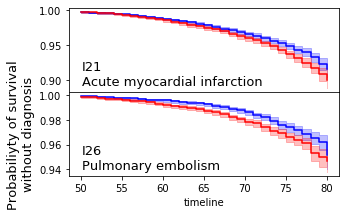

In [73]:
fig = plt.figure(figsize=(5.,5.))
gs = fig.add_gridspec(nrows=4,ncols=1,hspace=0.)
score_col = "adjusted_score" #"best_pval_score_homogenous"

for i, code in enumerate(["I21","I26"]):
    
    ax = fig.add_subplot(gs[i,0])
    
    events = all_ICD10_events.loc[all_ICD10_events.code == code]
    
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin",score_col] + list(set(pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_ = X_.loc[X_["T"] >= 30]
    assert X_["T"].isnull().sum() == 0
    
    a = 0.05
    low = X_[score_col] < X_[score_col].quantile(a)
    high = X_[score_col] > X_[score_col].quantile(1-a)
    
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(X_.loc[low,"T"],X_.loc[low,"EVENT"])
    kmf_low.plot_survival_function(loc=slice(50.,80.),label="Bottom %d%% of score" % int(100*a),legend=False,color="blue")

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(X_.loc[high,"T"],X_.loc[high,"EVENT"])
    kmf_high.plot_survival_function(loc=slice(50.,80.),label="Top %d%% of score" % int(100*a),legend=False,color="red")
    
    if i == 0:
        plt.xlabel("Age (years)",fontsize=13)
    elif i == 1:
        plt.ylabel("Probabiliyty of survival\nwithout diagnosis",fontsize=13)
    else:
        plt.xticks([])
        plt.xlabel(None)
    plt.title(None)
    plt.text(x=0.05,y=0.08,s="%s\n%s" % (code,ICD10_sec_desc[code][4:]),transform = ax.transAxes,fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/survival.pdf")
#plt.legend()
plt.savefig("/home/hv270/sysmex2pf/figures/survival_legend.pdf")

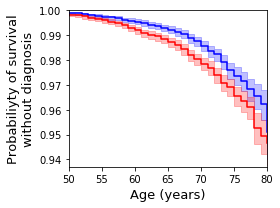

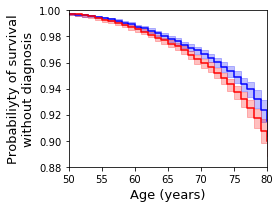

In [75]:
f = [0.063,0.12,0.44]
aspect_ratio = 3./4
import matplotlib.ticker as mtick
kmfs = {}
for i, code in enumerate(["I26","I21"]):
    
    fig, ax = plt.subplots(figsize=(4.,3.))
    
    events = all_ICD10_events.loc[all_ICD10_events.code == code]
    
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin",score_col] + list(set(pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_ = X_.loc[X_["T"] >= 30]
    assert X_["T"].isnull().sum() == 0
    #ax.set_aspect(aspect_ratio*30/f[i])
    ax.set_ylim((1-f[i],1.))
    ax.set_xlim((50,80))
    
    a = 0.05
    low = X_[score_col] < X_[score_col].quantile(a)
    high = X_[score_col] > X_[score_col].quantile(1-a)
    
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(X_.loc[low,"T"],X_.loc[low,"EVENT"])
    kmf_low.plot_survival_function(loc=slice(50.,80.),label="Bottom %d%% of score" % int(100*a),legend=False,color="blue")

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(X_.loc[high,"T"],X_.loc[high,"EVENT"])
    kmf_high.plot_survival_function(loc=slice(50.,80.),label="Top %d%% of score" % int(100*a),legend=False,color="red")
    
    plt.xlabel("Age (years)",fontsize=13)
    plt.ylabel("Probabiliyty of survival\nwithout diagnosis",fontsize=13)
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    #plt.title(ICD10_sec_desc[code])
    #plt.text(x=0.05,y=0.08,s=ICD10_sec_desc[code],transform = ax.transAxes,fontsize=13)
    plt.tight_layout()
    plt.savefig("/home/hv270/sysmex2pf/figures/survival_%s.pdf" % code)
    #plt.legend()
    #plt.savefig("/home/hv270/sysmex2pf/figures/survival_%s_legend.pdf" % code)
    
    kmfs[code] = (kmf_low, kmf_high)

In [84]:
kmfs["I26"][0].cumulative_density_.to_csv("%s/I26_lower_tail_cumulative_density.csv" % run_dir)
kmfs["I26"][1].cumulative_density_.to_csv("%s/I26_upper_tail_cumulative_density.csv" % run_dir)
kmfs["I21"][0].cumulative_density_.to_csv("%s/I21_lower_tail_cumulative_density.csv" % run_dir)
kmfs["I21"][1].cumulative_density_.to_csv("%s/I21_upper_tail_cumulative_density.csv" % run_dir)

In [ ]:
np.argmin(np.abs(bins-np.quantile(X_[score_col],0.05)))

In [ ]:
bins = np.linspace(X_[score_col].min(),X_[score_col].max(),85,endpoint=True)
#i_5 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.05)))
#i_95 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.95)))
#bins[i_5] = np.quantile(X_[score_col],0.05)
#bins[i_95] = np.quantile(X_[score_col],0.95)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
y_max = 8500
ax.set_ylim((0,y_max))
#ax.set_aspect(aspect_ratio*8/y_max)
ax.set_ylim((-4,4))
plt.hist(X_[score_col],bins=bins,color="gray",alpha=.4,orientation="horizontal");
plt.hist(X_.loc[low,score_col],bins=bins,color="blue",alpha=1,orientation="horizontal");
plt.hist(X_.loc[high,score_col],bins=bins,color="red",alpha=1,orientation="horizontal");
plt.ylabel("Adjusted platelet reactivity score",fontsize=13)
plt.xlabel("Number of UK Biobank\nparticipants",fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/score_hist.pdf")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-20000,20000)

In [ ]:
bins = np.linspace(X_[score_col].min(),X_[score_col].max(),101,endpoint=True)
b, c = np.histogram(X_[score_col],bins=50)

i_5 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.05)))
i_95 = np.argmin(np.abs(bins-np.quantile(X_[score_col],0.95)))
high_plot = X_[score_col] > bins[i_95]
low_plot = X_[score_col] < bins[i_5]

fig = plt.figure(figsize=(3,5))
ax = fig.add_subplot(111)
y_max = 8500
ax.set_xlim((-y_max,y_max))
#ax.set_aspect(aspect_ratio*8/y_max)
b, c = np.histogram(X_[score_col],bins=bins)
c_center = (c[1:]+c[:-1])/2
c_step = c[1]-c[0]
b_low, c = np.histogram(X_.loc[low_plot, score_col],bins=bins)
b_high, c = np.histogram(X_.loc[high_plot, score_col],bins=bins)

ax.set_ylim((-4,4))
ax.barh(y=c_center,width=b,height=c_step,left=-b/2,color="gray",alpha=.4)
ax.barh(y=c_center,width=b_low,height=c_step,left=-b_low/2,color="blue")
ax.barh(y=c_center,width=b_high,height=c_step,left=-b_high/2,color="red")
#plt.hist(X_[score_col],bins=bins,orientation="horizontal");
#plt.hist(X_.loc[low,score_col],bins=bins,color="blue",alpha=1,orientation="horizontal");
#plt.hist(X_.loc[high,score_col],bins=bins,color="red",alpha=1,orientation="horizontal");

plt.ylabel("Adjusted platelet reactivity score",fontsize=13)
plt.xlabel("Number of UK Biobank\nparticipants",fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/score_hist.pdf")

In [ ]:
fig = plt.figure(figsize=(2,5))
ax = fig.add_subplot(111)
c = ax.violinplot(X_[score_col], showmeans=False,showextrema=False,widths=[2.4])
for pc in c['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('grey')
c = ax.violinplot(X_.loc[low,score_col],showmeans=False,showextrema=False,bw_method=.03);
for pc in c['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')
    pc.set_alpha(1)
c = ax.violinplot(X_.loc[high,score_col],showmeans=False,showextrema=False,bw_method=.03);
for pc in c['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('red')
    pc.set_alpha(1)
ax.set_ylim((-4,4))
ax.set_xticks([])
ax.set_ylabel("Adjusted platelet reactivity score")

# Unused

In [ ]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)

In [ ]:
cox_and_GWAS = pd.merge(cox, gwas_results,left_on="SNP",right_on="SNP",how="left",suffixes=("_Cox","_GWAS"))\
    .rename(columns={"HR":"Hazard Ratio",
                     "corars":"Covariates used in Cox Regression",
                     "strata":"quartile (of # of cases)"})
cox_and_GWAS.to_csv("/home/hv270/sysmex2pf/GWAS_and_Cox.csv")

In [ ]:
per_SNP = cox.sort_values("P").groupby("SNP").first().sort_values("P")

In [ ]:
gwas_results.head(3)

In [ ]:
per_SNP = pd.merge(per_SNP,
         gwas_results[["SNP","CHR","BP","A1FREQ","was_in_NY_GWAS","PUBMED","SYMBOL","BETA"]],
         left_index=True,right_on="SNP",how="left")
per_SNP["isin_PUBMED"] = per_SNP.PUBMED != "-"

In [ ]:
per_SNP_export = per_SNP[["SNP","SYMBOL","P","desc","HR","BETA","covars","was_in_NY_GWAS","isin_PUBMED"]]\
    .rename(columns={"SYMBOL":"GENE (VEP selected)",
                     "P":"lowest P-value (Cox Regression)",
                     "HR":"hazard ratio",
                     "covars":"Covariates used"})

In [ ]:
per_SNP_export.to_csv("/home/hv270/sysmex2pf/cox_and_GWAS.csv")

In [ ]:
p = Pool(15)

for lt in tqdm(p.imap_unordered(compare_top_bottom, all_ICD10_events.groupby("code")),
              total=all_ICD10_events.code.nunique()):
    if lt is None: continue
    lt, desc = lt
    p_val = lt.summary["p"].iloc[0]
    if p_val < 1e-3:
        print(desc)
        print(lt.summary)
p.close()
p.join()

# Logistic regression

In [ ]:
pip install statsmodels

In [ ]:
from sklearn.linear_model import LogisticRegression
from statsmodels.api import GLM
from statsmodels.genmod import families

In [ ]:
for c in codes_to_focus_on:
    X[c] = X.index.isin(all_ICD10_events.loc[all_ICD10_events.code == c].ID.unique().tolist())

In [ ]:
X["anti_coag"] *= 1

In [ ]:
h1_cols = ["TOTAL_PFC","AGE"] #["AGE","thrombotic_event"]
h0_cols = ["AGE"] # ,"thrombotic_event"

for c in codes_to_focus_on:
    print(c)
    lr_just_score = GLM(X[c],X[["TOTAL_PFC","AGE"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_just_score.summary())
    lr_thrombotic = GLM(X[c],X[["TOTAL_PFC","AGE","thrombotic_event"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_thrombotic.summary())
    lr_anticoag = GLM(X[c],X[["TOTAL_PFC","AGE","anti_coag"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_anticoag.summary())
    lr_anticoag = GLM(X[c],X[["TOTAL_PFC","AGE","anti_coag","thrombotic_event"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_anticoag.summary())

In [ ]:
lr.coef_

In [ ]:
lr_null.coef_

# Simple Linear Regression

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
def do_linear_test(args, phenos):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: return None
    # get T column
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE"] + list(set(all_basics_ + pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    assert X_["T"].isnull().sum() == 0
    
    #print(X_.loc[X_.EVENT > 0].head())
    
    #only_old_people = X_["T"] >= 18
    #if only_old_people.mean() < .6:
    #    print("Keeping %.2f for %s" % (only_old_people.mean(),desc))
    #X_ = X_.loc[only_old_people]
    
    
    # find if unisex
    n_cases = X_.EVENT.sum()
    valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    
    # Define people to include and strata
    to_include = X_[SEX_FIELD].isin(valid_sexes)
    strata = [SEX_FIELD] if not unisex else []
    strata += [DIABETES_FIELD]
        
    X_ = X_.loc[to_include]
    
    n_cases = X_.EVENT.sum()
    if n_cases <= min_n_cases: return None
    
    p_vals = []
    HRs = []
    c_group = []
    pheno = []
    
    cols_to_normalize = [c for c in X_.columns if X_[c].dtype == float and c != "EVENT"]
    cols_to_normalize += ["T","2443-0.0"]
    
    X_[cols_to_normalize] -= X_[cols_to_normalize].mean(axis=0)
    X_[cols_to_normalize] /= X_[cols_to_normalize].std(axis=0)
    
    for covars_group in basics_:
        basics = list(basics_[covars_group]) + ["T"]
        if not unisex:
            basics += [SEX_FIELD]
        

        cols_to_include_1 = basics #+ pc_covars_cols[:3]
        lm1 = LogisticRegression(penalty="none",solver="sag")
        lm1.fit(X_[cols_to_include_1],X_["EVENT"] > 0)
        
        LP = lm1.predict_log_proba(X_[cols_to_include_1])
        LL_without = np.sum(np.where(X_["EVENT"],LP[:,1],LP[:,0]))
        for s in phenos:
            cols_to_include_2 = cols_to_include_1 + [s]
            
            lm2 = LogisticRegression(penalty="none",solver="sag")
            lm2.fit(X_[cols_to_include_2], X_["EVENT"] > 0)

            LP = lm2.predict_log_proba(X_[cols_to_include_2])
            LL_with = np.sum(np.where(X_["EVENT"] > 0,LP[:,1],LP[:,0]))
            
            
            Delta_LL = LL_with-LL_without
            
            p_val = 1.-chi2(1).cdf(2*Delta_LL)

            ### cox_info.loc[code, "p"] = p_val
            HR = lm2.coef_[0,-1]
            ### cox_info.loc[code, "HR"] = HR
            
            p_vals.append(p_val)
            HRs.append(HR)
            c_group.append(covars_group)
            pheno.append(s)

            description = ""
            description += "| %s \t| %s : %.2f\t" % (s, covars_group,-np.log10(p_val))
            description += "%d cases \t %s \t %s" % (n_cases, code, desc)
            if p_val < 1e-3:
                print("==========================")
                print(description)
                print("==========================")
    
    return code, p_vals, n_cases, desc, HRs, c_group, pheno

In [ ]:
basics_ = {#"none":[],
           #"sysmex":pc_covars_cols[:3],
           #"environmental":["SMOKING_RATE",BMI_FIELD,CHOLESTEROL_FIELD],
           "all":pc_covars_cols[:3] + ["SMOKING_RATE",BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD]}

In [ ]:
n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events)

In [ ]:
p = Pool(32)

codes_ = []
descs_ = []
n_cases_ = []
P_ = []
HR_ = []
phenos_ = []
covs_ = []

do_linear_test_pheno = partial(do_linear_test,phenos=pheno_cols)
for _ in tqdm(p.imap_unordered(do_linear_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=all_ICD10_events.loc[cond].code.nunique()):
    if _ is None: continue
    code, p_vals, n_cases, desc, HRs, covs, phenos = _
    for i in range(len(p_vals)):
        HR_.append(HRs[i])
        P_.append(p_vals[i])
        covs_.append(covs[i])
        codes_.append(code)
        descs_.append(desc)
        n_cases_.append(n_cases)
        phenos_.append(phenos[i])
p.close()
p.join()